# 사용 패키지

In [1]:
from fbprophet import Prophet
import fbprophet
print(fbprophet.__version__)

0.7.1


In [2]:
import os
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import *

import xgboost as xgb 
import lightgbm as lgb
import bayes_opt
import itertools

from bayes_opt import BayesianOptimization
# import pycaret

# 폰트 설정 - 윈도우
plt.rcParams['font.family'] = 'NanumGothic'

# 그래프의 크기
plt.rcParams['figure.figsize'] = 12, 6

# 글자 크기
plt.rcParams['font.size'] = 14

# 폰트 설정 시 - 기호 깨는거 방지하기
plt.rcParams['axes.unicode_minus'] = False

# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

In [3]:
def nmae(true_df, pred_df):
    # target_idx = true_df.iloc[:,0]
    # pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    # pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    # true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
    true = true_df.iloc[:].to_numpy()
    pred = pred_df.iloc[:].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

def nmae_values(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    
    return score

# 데이터 로드

In [4]:
total = pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [5]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [6]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [7]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [8]:
total.head()

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1


# 기상 데이터

In [10]:
seoul = pd.read_csv('./data/weather/seoul_test.csv', encoding = 'euc-kr')
seoul = seoul[['기온(°C)', '풍속(m/s)', '습도(%)', '지면온도(°C)']]
seoul.columns = ['기온', '풍속', '습도', '지면온도']
seoul

,기온,풍속,습도,지면온도
0,-8.5,4.0,57.0,-3.4
1,-8.4,4.0,60.0,-3.4
2,-8.1,3.4,58.0,-3.4
3,-8.2,3.8,58.0,-3.4
4,-8.2,4.4,61.0,-3.3
...,...,...,...,...
54739,4.9,2.6,24.0,2.3
54740,4.2,3.1,25.0,1.5
54741,3.6,2.8,28.0,0.8
54742,3.0,1.6,31.0,0.2


# 지역난방데이터

In [11]:
heat_data = pd.read_csv('./data/지역난방데이터전처리.csv')
heat_data_test = pd.read_csv('./data/지역난방데이터전처리_0331까지.csv')
heat_data_test = heat_data_test[['난방지수', '일시']]

# 전처리

구분 0 시행중


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


구분 0의 공급량 outlier 처리 전 plot


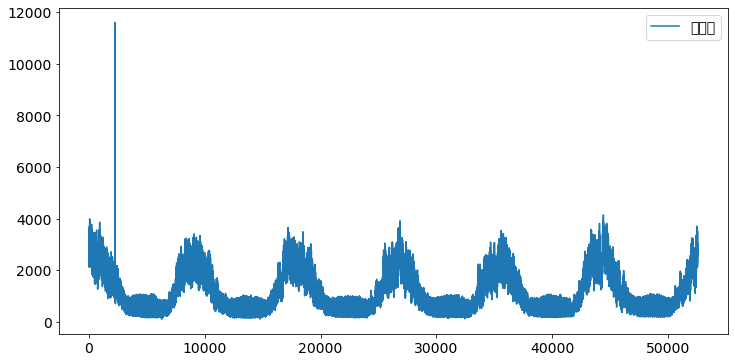

구분 0의 공급량 outlier 처리 후 plot


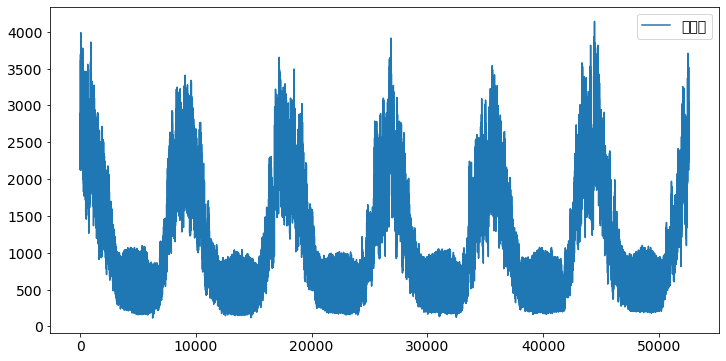

구분 1 시행중
구분 1의 공급량 outlier 처리 전 plot


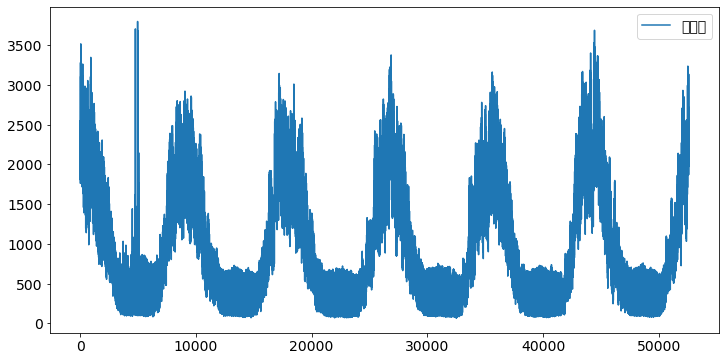

구분 1의 공급량 outlier 처리 후 plot


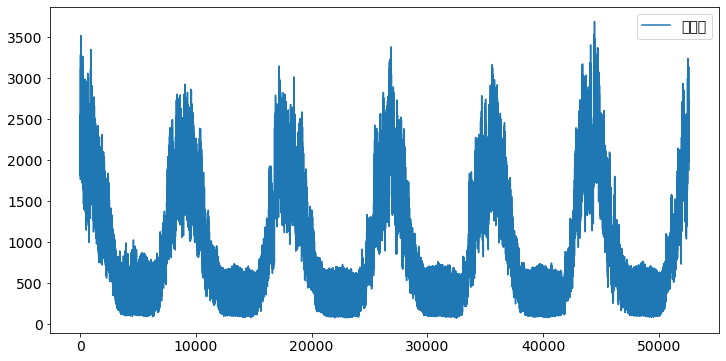

구분 2 시행중
구분 2의 공급량 outlier 처리 전 plot


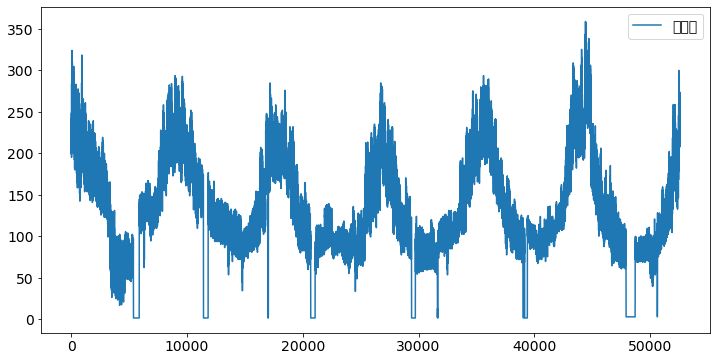

구분 2의 공급량 outlier 처리 후 plot


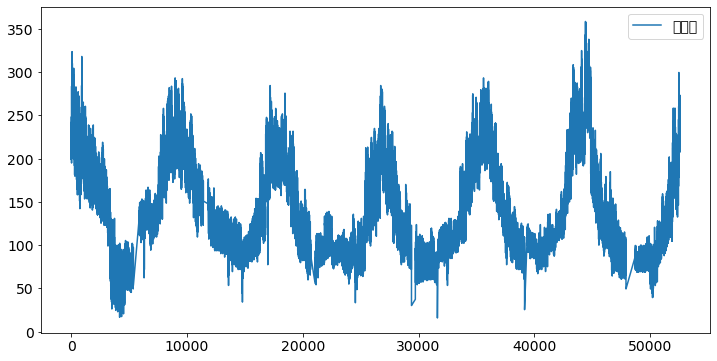

구분 3 시행중
구분 3의 공급량 outlier 처리 전 plot


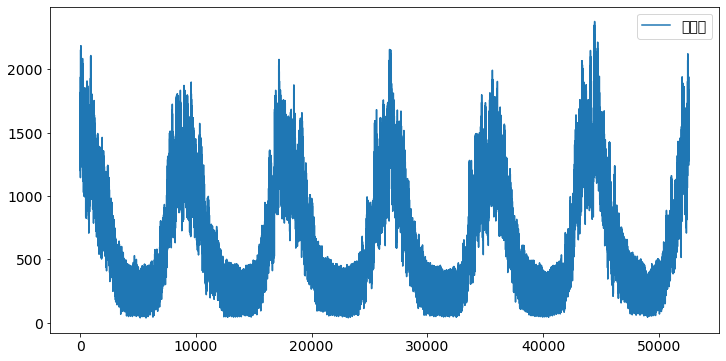

구분 3의 공급량 outlier 처리 후 plot


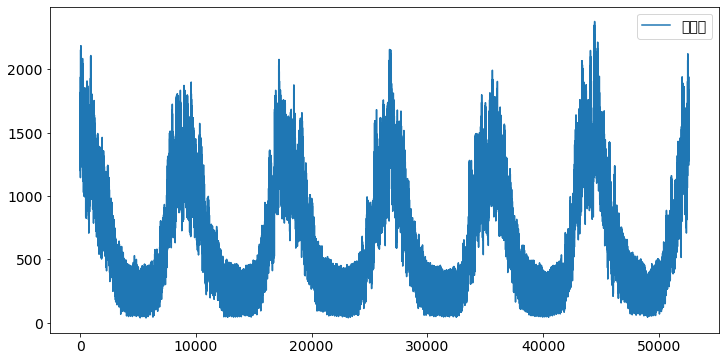

구분 4 시행중
구분 4의 공급량 outlier 처리 전 plot


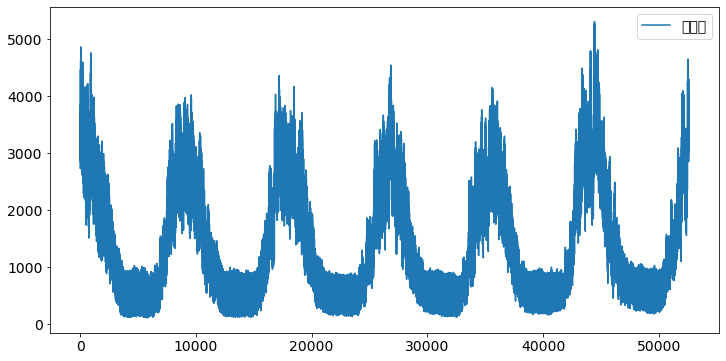

구분 4의 공급량 outlier 처리 후 plot


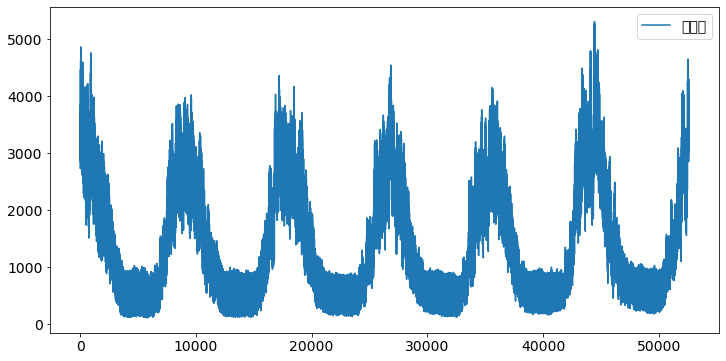

구분 5 시행중
구분 5의 공급량 outlier 처리 전 plot


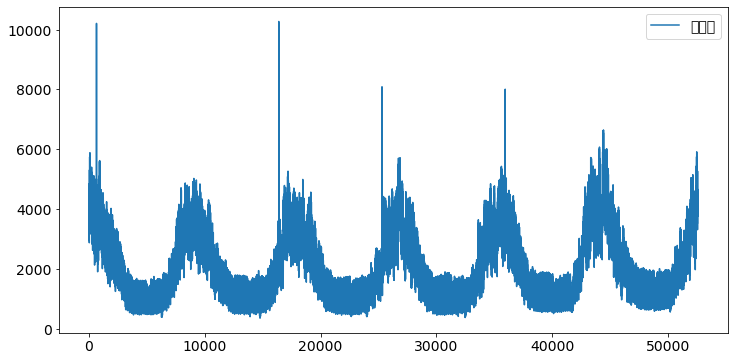

구분 5의 공급량 outlier 처리 후 plot


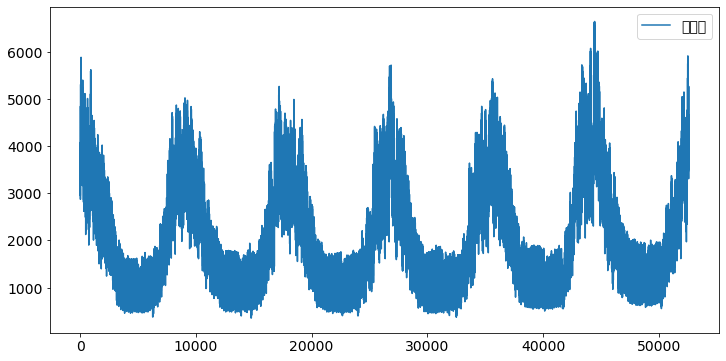

구분 6 시행중
구분 6의 공급량 outlier 처리 전 plot


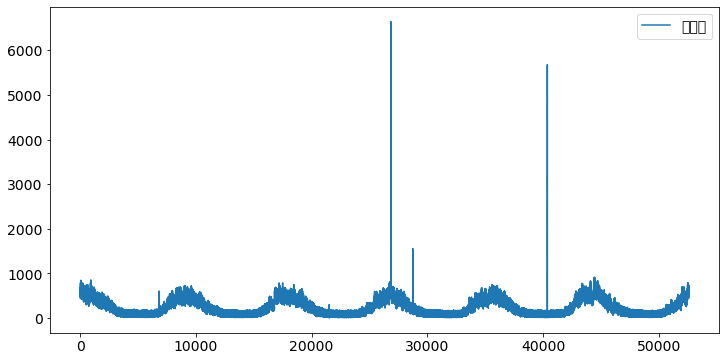

구분 6의 공급량 outlier 처리 후 plot


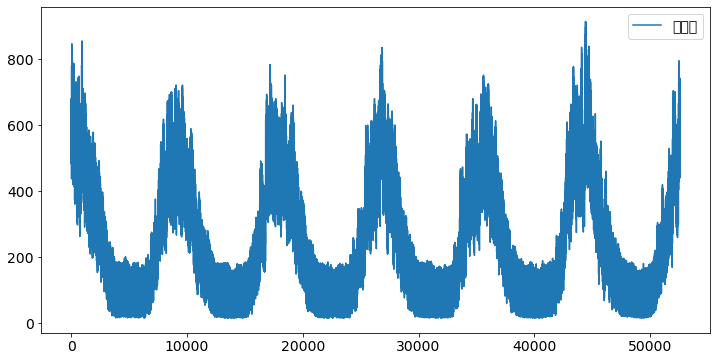

In [12]:
# 구분별로 함수를 사용해서 대체를 해보는 방법 ㄱㄱ
def outlier_prophet_ver3(data) :
  uniq = data['구분'].unique()
  result = pd.DataFrame()
  for i in uniq :
    print('구분 {} 시행중'.format(i))
    total_ = data[data['구분'] == i].reset_index()
    total_[['시간']] = total_[['시간']].astype('int') - 1
    total_[['시간']] = total_[['시간']].astype('str')
    total_['시간'] = total_['시간'].str.zfill(width=2)
    total_['일시'] = total_['연월일'].astype('str') + '-' + total_['시간'].astype('str')
    total_['일시']= pd.to_datetime(total_['일시'])
    # display(total_.head())
    df = data[data['구분'] == i].reset_index()
    print('구분 {}의 공급량 outlier 처리 전 plot'.format(i))
    df[['공급량']].plot()
    plt.show()
    df['aft_1hour'] = df['공급량'].shift(-1)
    df['bef_1hour'] = df['공급량'].shift(1)
    df['bef_diff'] = abs((df['bef_1hour'] - df['공급량'])/df['공급량'])
    df['aft_diff'] = abs((df['aft_1hour'] - df['공급량'])/df['공급량'])
    df['aft_remove'] = df['aft_diff'].shift(1)
    df['bef_remove'] = df['bef_diff'].shift(-1)
    idx = df[((df['bef_remove'] > 1) | (df['aft_remove'] > 1)) & (df['공급량'] > 100) | (df['공급량'] < 15)].index.tolist() #(round(df['공급량'], 3).isin([1.378, 2.756])
    df.at[idx, '공급량'] = np.nan

    df.공급량 = df.공급량.interpolate()
    print('구분 {}의 공급량 outlier 처리 후 plot'.format(i))
    df[['공급량']].plot()
    plt.show()
    
    total_ = pd.concat([total_.drop(['공급량'], axis = 1), df.공급량], axis = 1)
    total_ = total_.set_index(['index'])
    total_ = total_[['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '일시']]
#       total_.columns = ['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '일시']

    result = pd.concat([result, total_])
    
#     else : 
#       total_ = total_.set_index(['index'])
#       result = pd.concat([result, total_])

  return result.sort_index()    

total_ = outlier_prophet_ver3(total)

## 기온 결측값 대체(보간법) + testset 기온 추가 (prophet)

In [16]:
def weather_interpolate(weather_data) :
  df = weather_data.copy()
  col_idx = weather_data[['기온', '풍속', '습도', '지면온도']].isna().sum().index
  for col in col_idx :
    print('{}의 결측값 대체중'.format(col))
    df[[col]] = df[[col]].interpolate()
  print('완료')
  return df

weather_ = weather_interpolate(seoul)

기온의 결측값 대체중
풍속의 결측값 대체중
습도의 결측값 대체중
지면온도의 결측값 대체중
완료


## 기온반응함수

In [13]:
react = pd.read_csv('./data/한국가스공사_수도권 도시가스 수요의 기온반응함수_20191231.csv', encoding = 'euc-kr')
react.columns = ['기온', '기온반응도']
react

,기온,기온반응도
0,-20.0,0.81671
1,-19.9,0.81289
2,-19.8,0.80917
3,-19.7,0.80555
4,-19.6,0.80203
...,...,...
596,39.6,-0.50018
597,39.7,-0.48867
598,39.8,-0.47706
599,39.9,-0.46535


In [14]:
ind_react = pd.read_csv('./data/한국가스공사_서울 산업용 도시가스 수요의 기온반응함수_20171231.csv', encoding = 'euc-kr')
ind_react.columns = ['기온', '산업_기온반응도']
ind_react

,기온,산업_기온반응도
0,-20.0,0.05319
1,-19.9,0.05780
2,-19.8,0.06237
3,-19.7,0.06689
4,-19.6,0.07137
...,...,...
596,39.6,-0.54600
597,39.7,-0.55179
598,39.8,-0.55763
599,39.9,-0.56352


In [17]:
weather_ = pd.merge(weather_, react, how = 'left', on = '기온')
weather_ = pd.merge(weather_, ind_react, how = 'left', on = '기온')
weather_

,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도
0,-8.5,4.0,57.0,-3.4,0.81834,0.28609
1,-8.4,4.0,60.0,-3.4,0.82012,0.28578
2,-8.1,3.4,58.0,-3.4,0.82544,0.28469
3,-8.2,3.8,58.0,-3.4,0.82367,0.28508
4,-8.2,4.4,61.0,-3.3,0.82367,0.28508
...,...,...,...,...,...,...
54739,4.9,2.6,24.0,2.3,0.69123,0.08023
54740,4.2,3.1,25.0,1.5,0.72546,0.09372
54741,3.6,2.8,28.0,0.8,0.75204,0.10547
54742,3.0,1.6,31.0,0.2,0.77606,0.11733


In [18]:
weather_train = weather_[ : -2160]
weather_test = weather_[-2160 : ].reset_index(drop = True)

In [19]:
def weather_merge(data, weather_data) :
  total = pd.DataFrame()
  for i in data['구분'].unique() :
    df = data[data['구분'] == i].reset_index()
    weather_df = weather_data.copy()
    weather_df['일시'] = df['일시']
    df = pd.merge(df, weather_df)
    # display(df)
    df = df.set_index('index')
    total = pd.concat([total, df])
  return total.sort_index()

total_weather = weather_merge(total_, weather_train)

In [20]:
total_weather

,연월일,시간,구분,공급량,year,month,day,weekday,일시,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도
index,,,,,,,,,,,,,,,
0,2013-01-01,00,0,2497.129,2013,1,1,1,2013-01-01 00:00:00,-8.5,4.0,57.0,-3.4,0.81834,0.28609
1,2013-01-01,01,0,2363.265,2013,1,1,1,2013-01-01 01:00:00,-8.4,4.0,60.0,-3.4,0.82012,0.28578
2,2013-01-01,02,0,2258.505,2013,1,1,1,2013-01-01 02:00:00,-8.1,3.4,58.0,-3.4,0.82544,0.28469
3,2013-01-01,03,0,2243.969,2013,1,1,1,2013-01-01 03:00:00,-8.2,3.8,58.0,-3.4,0.82367,0.28508
4,2013-01-01,04,0,2344.105,2013,1,1,1,2013-01-01 04:00:00,-8.2,4.4,61.0,-3.3,0.82367,0.28508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,19,6,681.033,2018,12,31,0,2018-12-31 19:00:00,-3.7,0.8,39.0,-3.0,0.87942,0.24080
368084,2018-12-31,20,6,669.961,2018,12,31,0,2018-12-31 20:00:00,-4.6,1.1,44.0,-4.1,0.87371,0.25341
368085,2018-12-31,21,6,657.941,2018,12,31,0,2018-12-31 21:00:00,-5.4,1.3,46.0,-5.0,0.86584,0.26323


In [21]:
test = pd.read_csv('./data/test.csv')
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]
  
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday
test['구분'] = test['구분'].map(d_map)

df = pd.DataFrame()
for i in test['구분'].unique() :
  test_ = test[test['구분'] == i].reset_index()
  test_[['시간']] = test_[['시간']].astype('int') - 1
  test_[['시간']] = test_[['시간']].astype('str')
  test_['시간'] = test_['시간'].str.zfill(width=2)
  test_['일시'] = test_['일자'].astype('str') + '-' + total_['시간'].astype('str')
  test_['일시']= pd.to_datetime(test_['일시'])
  df = pd.concat([df, test_])

test_ = df.set_index('index')

In [22]:
def test_weather_merge(data, weather_data) :
  total = pd.DataFrame()
  for i in data['구분'].unique() :
    df = data[data['구분'] == i].reset_index()
    weather_df = weather_data.copy()
    weather_df['일시'] = df['일시']
    df = pd.merge(df, weather_df)
    # display(df)
    df = df.set_index('index')
    total = pd.concat([total, df])
  return total.sort_index()

test_weather = test_weather_merge(test_, weather_test)

In [23]:
test_weather

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,일시,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도
index,,,,,,,,,,,,,,,
0,2019-01-01 01 A,2019-01-01,00,0,2019,1,1,1,2019-01-01 00:00:00,-5.9,1.8,56.0,-6.5,0.85977,0.26864
1,2019-01-01 02 A,2019-01-01,01,0,2019,1,1,1,2019-01-01 01:00:00,-6.5,1.2,60.0,-7.1,0.85149,0.27433
2,2019-01-01 03 A,2019-01-01,02,0,2019,1,1,1,2019-01-01 02:00:00,-6.9,2.2,62.0,-7.3,0.84544,0.27759
3,2019-01-01 04 A,2019-01-01,03,0,2019,1,1,1,2019-01-01 03:00:00,-7.2,1.2,57.0,-7.5,0.84068,0.27976
4,2019-01-01 05 A,2019-01-01,04,0,2019,1,1,1,2019-01-01 04:00:00,-7.6,2.1,59.0,-7.8,0.83406,0.28224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,19,6,2019,3,31,6,2019-03-31 19:00:00,4.9,2.6,24.0,2.3,0.69123,0.08023
15116,2019-03-31 21 H,2019-03-31,20,6,2019,3,31,6,2019-03-31 20:00:00,4.2,3.1,25.0,1.5,0.72546,0.09372
15117,2019-03-31 22 H,2019-03-31,21,6,2019,3,31,6,2019-03-31 21:00:00,3.6,2.8,28.0,0.8,0.75204,0.10547


# 지역난방데이터 추가

In [24]:
heat_train = heat_data_test[ : -2160]
heat_test = heat_data_test[-2160 : ].reset_index(drop = True)

In [25]:
heat_train['일시'] = pd.to_datetime(heat_train['일시'])
heat_test['일시'] = pd.to_datetime(heat_test['일시'])

In [26]:
def heat_merge(data, heat_data) :
  total = pd.DataFrame()
  for i in data['구분'].unique() :
    df = data[data['구분'] == i].reset_index()
    df = pd.merge(df, heat_data)
    df = df.set_index('index')
    total = pd.concat([total, df])
  return total.sort_index()

total_heat = heat_merge(total_weather, heat_train)
test_heat = heat_merge(test_weather, heat_test)

In [27]:
total_heat.columns = ['일자', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '일시', '기온', '풍속', '습도', '지면온도', '기온반응도', '산업_기온반응도', '난방지수']
total_heat

,일자,시간,구분,공급량,year,month,day,weekday,일시,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수
index,,,,,,,,,,,,,,,,
0,2013-01-01,00,0,2497.129,2013,1,1,1,2013-01-01 00:00:00,-8.5,4.0,57.0,-3.4,0.81834,0.28609,10695.0
1,2013-01-01,01,0,2363.265,2013,1,1,1,2013-01-01 01:00:00,-8.4,4.0,60.0,-3.4,0.82012,0.28578,10186.0
2,2013-01-01,02,0,2258.505,2013,1,1,1,2013-01-01 02:00:00,-8.1,3.4,58.0,-3.4,0.82544,0.28469,9765.0
3,2013-01-01,03,0,2243.969,2013,1,1,1,2013-01-01 03:00:00,-8.2,3.8,58.0,-3.4,0.82367,0.28508,9468.0
4,2013-01-01,04,0,2344.105,2013,1,1,1,2013-01-01 04:00:00,-8.2,4.4,61.0,-3.3,0.82367,0.28508,9378.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,19,6,681.033,2018,12,31,0,2018-12-31 19:00:00,-3.7,0.8,39.0,-3.0,0.87942,0.24080,10267.0
368084,2018-12-31,20,6,669.961,2018,12,31,0,2018-12-31 20:00:00,-4.6,1.1,44.0,-4.1,0.87371,0.25341,10752.0
368085,2018-12-31,21,6,657.941,2018,12,31,0,2018-12-31 21:00:00,-5.4,1.3,46.0,-5.0,0.86584,0.26323,11190.0


In [28]:
test_heat

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,일시,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수
index,,,,,,,,,,,,,,,,
0,2019-01-01 01 A,2019-01-01,00,0,2019,1,1,1,2019-01-01 00:00:00,-5.9,1.8,56.0,-6.5,0.85977,0.26864,9766.0
1,2019-01-01 02 A,2019-01-01,01,0,2019,1,1,1,2019-01-01 01:00:00,-6.5,1.2,60.0,-7.1,0.85149,0.27433,9503.0
2,2019-01-01 03 A,2019-01-01,02,0,2019,1,1,1,2019-01-01 02:00:00,-6.9,2.2,62.0,-7.3,0.84544,0.27759,9335.0
3,2019-01-01 04 A,2019-01-01,03,0,2019,1,1,1,2019-01-01 03:00:00,-7.2,1.2,57.0,-7.5,0.84068,0.27976,8996.0
4,2019-01-01 05 A,2019-01-01,04,0,2019,1,1,1,2019-01-01 04:00:00,-7.6,2.1,59.0,-7.8,0.83406,0.28224,8868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,19,6,2019,3,31,6,2019-03-31 19:00:00,4.9,2.6,24.0,2.3,0.69123,0.08023,6311.0
15116,2019-03-31 21 H,2019-03-31,20,6,2019,3,31,6,2019-03-31 20:00:00,4.2,3.1,25.0,1.5,0.72546,0.09372,6786.0
15117,2019-03-31 22 H,2019-03-31,21,6,2019,3,31,6,2019-03-31 21:00:00,3.6,2.8,28.0,0.8,0.75204,0.10547,7059.0


In [29]:
data = pd.concat([total_heat, test_heat]).reset_index(drop = True)
data.drop(['일자|시간|구분'], axis = 1, inplace = True)
data

,일자,시간,구분,공급량,year,month,day,weekday,일시,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수
0,2013-01-01,00,0,2497.129,2013,1,1,1,2013-01-01 00:00:00,-8.5,4.0,57.0,-3.4,0.81834,0.28609,10695.0
1,2013-01-01,01,0,2363.265,2013,1,1,1,2013-01-01 01:00:00,-8.4,4.0,60.0,-3.4,0.82012,0.28578,10186.0
2,2013-01-01,02,0,2258.505,2013,1,1,1,2013-01-01 02:00:00,-8.1,3.4,58.0,-3.4,0.82544,0.28469,9765.0
3,2013-01-01,03,0,2243.969,2013,1,1,1,2013-01-01 03:00:00,-8.2,3.8,58.0,-3.4,0.82367,0.28508,9468.0
4,2013-01-01,04,0,2344.105,2013,1,1,1,2013-01-01 04:00:00,-8.2,4.4,61.0,-3.3,0.82367,0.28508,9378.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383203,2019-03-31,19,6,NaN,2019,3,31,6,2019-03-31 19:00:00,4.9,2.6,24.0,2.3,0.69123,0.08023,6311.0
383204,2019-03-31,20,6,NaN,2019,3,31,6,2019-03-31 20:00:00,4.2,3.1,25.0,1.5,0.72546,0.09372,6786.0
383205,2019-03-31,21,6,NaN,2019,3,31,6,2019-03-31 21:00:00,3.6,2.8,28.0,0.8,0.75204,0.10547,7059.0
383206,2019-03-31,22,6,NaN,2019,3,31,6,2019-03-31 22:00:00,3.0,1.6,31.0,0.2,0.77606,0.11733,6762.0


# 기타 features 합치기

## 수입금액지수

In [30]:
imp_wage = pd.read_csv('./data/수입금액지수_천연가스.csv', encoding = 'euc-kr')
imp_wage

,일시,수입금액지수_천연가스
0,2013-01-01,193.49
1,2013-02-01,204.18
2,2013-03-01,210.42
3,2013-04-01,166.03
4,2013-05-01,140.76
...,...,...
70,2018-11-01,145.58
71,2018-12-01,172.60
72,2019-01-01,143.13
73,2019-02-01,148.47


## 수입물가지수

In [31]:
imp_price = pd.read_csv('./data/수입물가지수(품목별).csv', encoding = 'euc-kr')
imp_price

,일시,수입물가지수(원화)
0,13-Jan,143.53
1,13-Feb,148.58
2,13-Mar,151.37
3,13-Apr,151.01
4,13-May,148.94
...,...,...
70,18-Nov,115.62
71,18-Dec,114.82
72,19-Jan,117.27
73,19-Feb,120.01


## 수입물량지수

In [32]:
imp_volume = pd.read_csv('./data/수입물량지수_천연가스.csv', encoding = 'euc-kr')
imp_volume

,일시,수입물량지수_천연가스
0,2013-01-01,138.70
1,2013-02-01,142.15
2,2013-03-01,144.35
3,2013-04-01,113.39
4,2013-05-01,98.08
...,...,...
70,2018-11-01,137.00
71,2018-12-01,162.74
72,2019-01-01,132.04
73,2019-02-01,133.88


## 에너지 소비량

In [33]:
energy = pd.read_csv('./data/에너지_소비량.csv', encoding = 'euc-kr')
energy

,Date,소비량
0,13-Jan,6487
1,13-Feb,5291
2,13-Mar,4781
3,13-Apr,4348
4,13-May,3612
...,...,...
70,18-Nov,4772
71,18-Dec,6381
72,19-Jan,6580
73,19-Feb,5339


## 4개의 데이터 한번에 합치기

In [34]:
etc_features = pd.concat([imp_volume, imp_wage[['수입금액지수_천연가스']], imp_price[['수입물가지수(원화)']], energy[['소비량']]], axis = 1)
etc_features.columns = ['일자', '수입물량지수_천연가스', '수입금액지수_천연가스', '수입물가지수(원화)', '소비량']
etc_features['일자'] = pd.to_datetime(etc_features['일자'])
etc_features

,일자,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,2013-01-01,138.70,193.49,143.53,6487
1,2013-02-01,142.15,204.18,148.58,5291
2,2013-03-01,144.35,210.42,151.37,4781
3,2013-04-01,113.39,166.03,151.01,4348
4,2013-05-01,98.08,140.76,148.94,3612
...,...,...,...,...,...
70,2018-11-01,137.00,145.58,115.62,4772
71,2018-12-01,162.74,172.60,114.82,6381
72,2019-01-01,132.04,143.13,117.27,6580
73,2019-02-01,133.88,148.47,120.01,5339


In [35]:
df = pd.merge(data, etc_features, how = 'outer', on = '일자')

In [36]:
df = df.fillna(method='ffill')
df.drop(['일시'], axis = 1, inplace = True)
df[['시간']] = df[['시간']].astype('int') + 1
df

,일자,시간,구분,공급량,year,month,day,weekday,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,2013-01-01,1,0,2497.129,2013,1,1,1,-8.5,4.0,57.0,-3.4,0.81834,0.28609,10695.0,138.7,193.49,143.53,6487.0
1,2013-01-01,2,0,2363.265,2013,1,1,1,-8.4,4.0,60.0,-3.4,0.82012,0.28578,10186.0,138.7,193.49,143.53,6487.0
2,2013-01-01,3,0,2258.505,2013,1,1,1,-8.1,3.4,58.0,-3.4,0.82544,0.28469,9765.0,138.7,193.49,143.53,6487.0
3,2013-01-01,4,0,2243.969,2013,1,1,1,-8.2,3.8,58.0,-3.4,0.82367,0.28508,9468.0,138.7,193.49,143.53,6487.0
4,2013-01-01,5,0,2344.105,2013,1,1,1,-8.2,4.4,61.0,-3.3,0.82367,0.28508,9378.0,138.7,193.49,143.53,6487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383203,2019-03-31,20,6,560.896,2019,3,31,6,4.9,2.6,24.0,2.3,0.69123,0.08023,6311.0,96.8,99.68,112.27,4984.0
383204,2019-03-31,21,6,560.896,2019,3,31,6,4.2,3.1,25.0,1.5,0.72546,0.09372,6786.0,96.8,99.68,112.27,4984.0
383205,2019-03-31,22,6,560.896,2019,3,31,6,3.6,2.8,28.0,0.8,0.75204,0.10547,7059.0,96.8,99.68,112.27,4984.0
383206,2019-03-31,23,6,560.896,2019,3,31,6,3.0,1.6,31.0,0.2,0.77606,0.11733,6762.0,96.8,99.68,112.27,4984.0


In [37]:
tmp = pd.DataFrame()
for i in df['구분'].unique() :
  tmp_df = df[df['구분'] == i].reset_index(drop = True)
  tmp = pd.concat([tmp, tmp_df])
df = tmp

In [38]:
df_train = df[~df['year'].isin([2019])].reset_index(drop = True)
df_test = df[df['year'].isin([2019])].reset_index(drop = True)
df_test['공급량'] = np.nan

In [39]:
display(df_train.head())
display(df_test.head())

,일자,시간,구분,공급량,year,month,day,weekday,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,2013-01-01,1,0,2497.129,2013,1,1,1,-8.5,4.0,57.0,-3.4,0.81834,0.28609,10695.0,138.7,193.49,143.53,6487.0
1,2013-01-01,2,0,2363.265,2013,1,1,1,-8.4,4.0,60.0,-3.4,0.82012,0.28578,10186.0,138.7,193.49,143.53,6487.0
2,2013-01-01,3,0,2258.505,2013,1,1,1,-8.1,3.4,58.0,-3.4,0.82544,0.28469,9765.0,138.7,193.49,143.53,6487.0
3,2013-01-01,4,0,2243.969,2013,1,1,1,-8.2,3.8,58.0,-3.4,0.82367,0.28508,9468.0,138.7,193.49,143.53,6487.0
4,2013-01-01,5,0,2344.105,2013,1,1,1,-8.2,4.4,61.0,-3.3,0.82367,0.28508,9378.0,138.7,193.49,143.53,6487.0


,일자,시간,구분,공급량,year,month,day,weekday,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,2019-01-01,1,0,NaN,2019,1,1,1,-5.9,1.8,56.0,-6.5,0.85977,0.26864,9766.0,132.04,143.13,117.27,6580.0
1,2019-01-01,2,0,NaN,2019,1,1,1,-6.5,1.2,60.0,-7.1,0.85149,0.27433,9503.0,132.04,143.13,117.27,6580.0
2,2019-01-01,3,0,NaN,2019,1,1,1,-6.9,2.2,62.0,-7.3,0.84544,0.27759,9335.0,132.04,143.13,117.27,6580.0
3,2019-01-01,4,0,NaN,2019,1,1,1,-7.2,1.2,57.0,-7.5,0.84068,0.27976,8996.0,132.04,143.13,117.27,6580.0
4,2019-01-01,5,0,NaN,2019,1,1,1,-7.6,2.1,59.0,-7.8,0.83406,0.28224,8868.0,132.04,143.13,117.27,6580.0


# 데이터 스케일링

In [40]:
num_columns = ['기온', '풍속', '습도', '지면온도', '기온반응도', '산업_기온반응도', '난방지수', '수입물량지수_천연가스', '수입금액지수_천연가스', '수입물가지수(원화)', '소비량']
num_train = df_train[num_columns]
cat_train = df_train.drop(num_columns, axis = 1)

num_test = df_test[num_columns]
cat_test = df_test.drop(num_columns, axis = 1)

In [41]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
num_train_scaled = scaler.fit_transform(num_train)
num_test_scaled = scaler.transform(num_test)

In [42]:
train = pd.concat([cat_train, pd.DataFrame(num_train_scaled, columns = num_columns)], axis = 1)
test = pd.concat([cat_test, pd.DataFrame(num_test_scaled, columns = num_columns)], axis = 1)

In [43]:
display(train.head())
display(test.head())

,일자,시간,구분,공급량,year,month,day,weekday,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,2013-01-01,1,0,2497.129,2013,1,1,1,-1.926215,1.187227,-0.126217,-1.371571,1.191820,2.089773,2.317378,1.006479,1.555055,1.091602,2.089817
1,2013-01-01,2,0,2363.265,2013,1,1,1,-1.917339,1.187227,0.024342,-1.371571,1.194257,2.087557,2.144745,1.006479,1.555055,1.091602,2.089817
2,2013-01-01,3,0,2258.505,2013,1,1,1,-1.890713,0.745558,-0.076031,-1.371571,1.201541,2.079764,2.001958,1.006479,1.555055,1.091602,2.089817
3,2013-01-01,4,0,2243.969,2013,1,1,1,-1.899588,1.040004,-0.076031,-1.371571,1.199118,2.082552,1.901228,1.006479,1.555055,1.091602,2.089817
4,2013-01-01,5,0,2344.105,2013,1,1,1,-1.899588,1.481672,0.074528,-1.364079,1.199118,2.082552,1.870703,1.006479,1.555055,1.091602,2.089817


,일자,시간,구분,공급량,year,month,day,weekday,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,난방지수,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,2019-01-01,1,0,NaN,2019,1,1,1,-1.695453,-0.432224,-0.176404,-1.603808,1.248547,1.965012,2.002298,0.765788,0.533482,0.289663,2.169768
1,2019-01-01,2,0,NaN,2019,1,1,1,-1.748706,-0.873893,0.024342,-1.648757,1.237210,2.005693,1.913098,0.765788,0.533482,0.289663,2.169768
2,2019-01-01,3,0,NaN,2019,1,1,1,-1.784207,-0.137778,0.124714,-1.663740,1.228926,2.029001,1.856119,0.765788,0.533482,0.289663,2.169768
3,2019-01-01,4,0,NaN,2019,1,1,1,-1.810834,-0.873893,-0.126217,-1.678723,1.222408,2.044516,1.741144,0.765788,0.533482,0.289663,2.169768
4,2019-01-01,5,0,NaN,2019,1,1,1,-1.846336,-0.211390,-0.025845,-1.701198,1.213344,2.062247,1.697731,0.765788,0.533482,0.289663,2.169768


<AxesSubplot:>

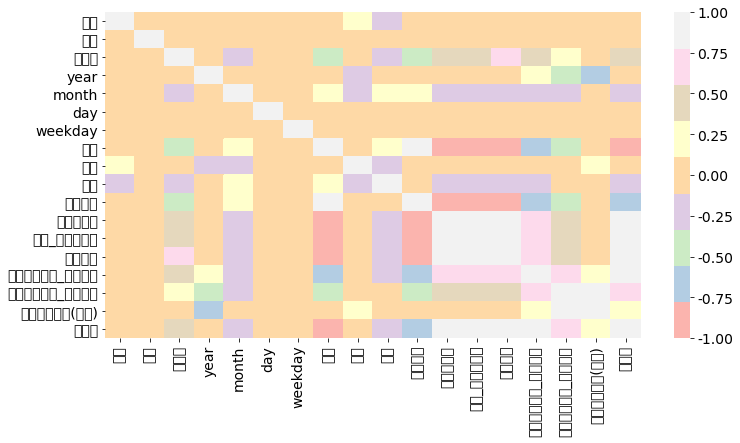

In [44]:
sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, cmap = 'Pastel1')

# 학습

In [397]:
def model_train(x_train, y_train, x_valid, y_valid) :
    params = {'learning_rate': 0.01, 
              'objective': 'regression',  
              'metric':'mae',
              'seed':42
             }

    
    model = lgb.train(params, 
                           categorical_feature = ['year', 'month', 'day', 'weekday', '시간'],
                           train_set = lgb.Dataset(data = x_train, label = y_train),
                           num_boost_round = 10000,
                           valid_sets = lgb.Dataset(data = x_valid, label = y_valid), 
                           init_model = None, 
                           early_stopping_rounds = 100,
                           verbose_eval = 50
                          )
    
    return model

In [398]:
train = pd.concat([cat_train, pd.DataFrame(num_train_scaled, columns = num_columns)], axis = 1)
test = pd.concat([cat_test, pd.DataFrame(num_test_scaled, columns = num_columns)], axis = 1)
# train = df_train.copy()
# test = df_test.copy()
train.drop(['일자', '난방지수'], axis = 1, inplace = True)
test.drop(['일자', '난방지수'], axis = 1, inplace = True)
# train.drop(['일자', '난방지수', '산업_기온반응도', '습도', '풍속', '지면온도'], axis = 1, inplace = True)
# test.drop(['일자', '난방지수', '산업_기온반응도', '습도', '풍속', '지면온도'], axis = 1, inplace = True)
train

,시간,구분,공급량,year,month,day,weekday,기온,풍속,습도,지면온도,기온반응도,산업_기온반응도,수입물량지수_천연가스,수입금액지수_천연가스,수입물가지수(원화),소비량
0,1,0,2497.129,2013,1,1,1,-1.926215,1.187227,-0.126217,-1.371571,1.191820,2.089773,1.006479,1.555055,1.091602,2.089817
1,2,0,2363.265,2013,1,1,1,-1.917339,1.187227,0.024342,-1.371571,1.194257,2.087557,1.006479,1.555055,1.091602,2.089817
2,3,0,2258.505,2013,1,1,1,-1.890713,0.745558,-0.076031,-1.371571,1.201541,2.079764,1.006479,1.555055,1.091602,2.089817
3,4,0,2243.969,2013,1,1,1,-1.899588,1.040004,-0.076031,-1.371571,1.199118,2.082552,1.006479,1.555055,1.091602,2.089817
4,5,0,2344.105,2013,1,1,1,-1.899588,1.481672,0.074528,-1.364079,1.199118,2.082552,1.006479,1.555055,1.091602,2.089817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,20,6,681.033,2018,12,31,0,-1.500193,-1.168338,-1.029570,-1.341605,1.275452,1.765965,1.875279,1.131293,0.214843,1.998690
368084,21,6,669.961,2018,12,31,0,-1.580072,-0.947504,-0.778639,-1.424011,1.267634,1.856122,1.875279,1.131293,0.214843,1.998690
368085,22,6,657.941,2018,12,31,0,-1.651076,-0.800281,-0.678266,-1.491435,1.256858,1.926332,1.875279,1.131293,0.214843,1.998690
368086,23,6,610.953,2018,12,31,0,-1.633325,-0.579447,-0.628080,-1.498927,1.259857,1.909745,1.875279,1.131293,0.214843,1.998690


In [399]:
model_dict = {}
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

for kind in train['구분'].unique() :
  # 품목 품종별 전처리
  temp_df = train[train['구분'] == kind].reset_index(drop = True)
  temp_df.drop(['구분'], axis=1, inplace = True)
  # 학습 진행
  tmp_train = temp_df[temp_df['year'].isin(train_years)]
  val = temp_df[temp_df['year'].isin(val_years)]
  # val = val.iloc[ : 2160]

  x_train = tmp_train.drop(['공급량'], axis = 1)
  y_train = tmp_train['공급량']

  x_valid = val.drop(['공급량'], axis = 1)
  y_valid = val['공급량']

  model_dict[f'{kind}_model'] = model_train(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 382.522
[100]	valid_0's l1: 247.169
[150]	valid_0's l1: 172.727
[200]	valid_0's l1: 135.294
[250]	valid_0's l1: 118.032
[300]	valid_0's l1: 109.982
[350]	valid_0's l1: 104.28
[400]	valid_0's l1: 101.001
[450]	valid_0's l1: 100.121
[500]	valid_0's l1: 98.5044
[550]	valid_0's l1: 97.956
[600]	valid_0's l1: 97.5058
[650]	valid_0's l1: 97.295
[700]	valid_0's l1: 97.2456
[750]	valid_0's l1: 97.2587
[800]	valid_0's l1: 97.1757
[850]	valid_0's l1: 97.0993
[900]	valid_0's l1: 97.0942
[950]	valid_0's l1: 96.9881
[1000]	valid_0's l1: 96.964
[1050]	valid_0's l1: 96.902
[1100]	valid_0's l1: 96.8245
[1150]	valid_0's l1: 96.8178
[1200]	valid_0's l1: 96.7494
[1250]	valid_0's l1: 96.7354
[1300]	valid_0's l1: 96.7627
[1350]	valid_0's l1: 96.7739
Early stopping, best iteration is:
[1270]	valid_0's l1: 96.7127
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l1: 380.348
[100]	valid_0's l1: 258.7

In [407]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/sample_submission.csv')
res = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/모든변수추가_standardscale_2.csv')
res2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/모든변수추가_난방지수제거_standardscale.csv')

In [408]:
for kind in test['구분'].unique():
    # 구분별 전처리
    idx = test[test['구분'] == kind].index
    test_df = test[test['구분'] == kind].reset_index(drop = True)
    test_df.drop(['구분', '공급량'], axis=1, inplace=True)
    
    # 수요 예측
    temp_model = model_dict[f'{kind}_model']
    result = temp_model.predict(test_df)
    sub['공급량'].loc[idx] = result

In [409]:
sub

,일자|시간|구분,공급량
0,2019-01-01 01 A,2094.660427
1,2019-01-01 02 A,1924.070061
2,2019-01-01 03 A,1879.125913
3,2019-01-01 04 A,1904.011449
4,2019-01-01 05 A,2052.578524
...,...,...
15115,2019-03-31 20 H,461.469129
15116,2019-03-31 21 H,459.851119
15117,2019-03-31 22 H,432.395164
15118,2019-03-31 23 H,399.905309


In [410]:
res

,일자|시간|구분,공급량
0,2019-01-01 01 A,2093.390160
1,2019-01-01 02 A,1908.131058
2,2019-01-01 03 A,1867.032755
3,2019-01-01 04 A,1907.199652
4,2019-01-01 05 A,1991.623672
...,...,...
15115,2019-03-31 20 H,452.622523
15116,2019-03-31 21 H,450.346545
15117,2019-03-31 22 H,433.173574
15118,2019-03-31 23 H,385.602878


In [411]:
res2

,일자|시간|구분,공급량
0,2019-01-01 01 A,2096.306192
1,2019-01-01 02 A,1905.267876
2,2019-01-01 03 A,1866.570125
3,2019-01-01 04 A,1894.854203
4,2019-01-01 05 A,2035.706427
...,...,...
15115,2019-03-31 20 H,450.983615
15116,2019-03-31 21 H,451.839853
15117,2019-03-31 22 H,429.276591
15118,2019-03-31 23 H,394.478888


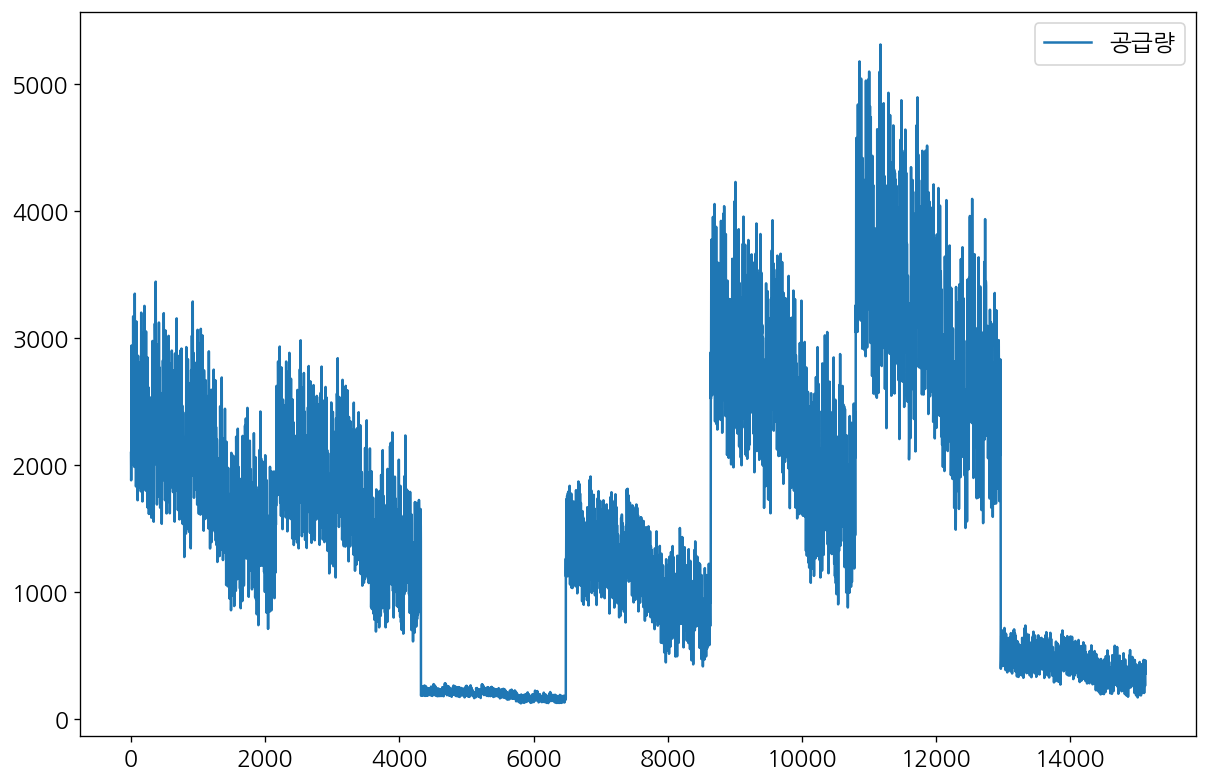

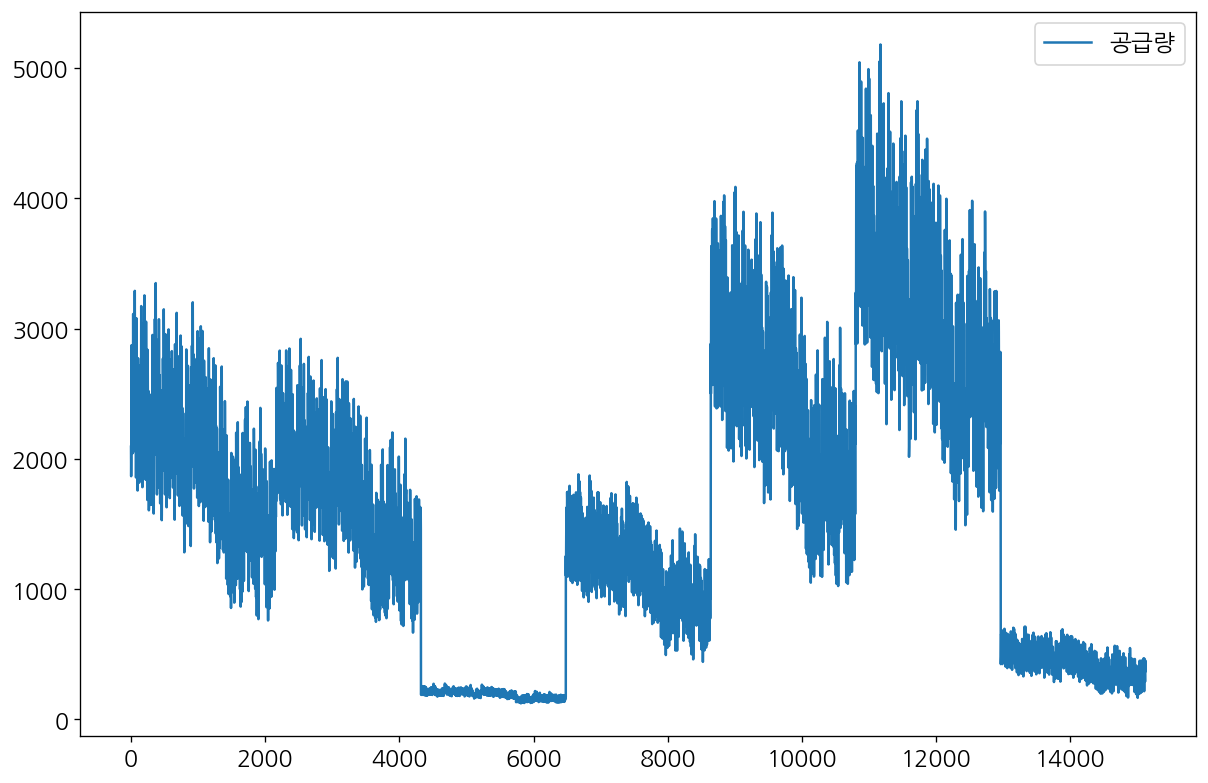

In [412]:
sub[['공급량']].plot()
res[['공급량']].plot()

In [413]:
print(nmae(sub[['공급량']], res[['공급량']]))
print(nmae(sub[['공급량']], res2[['공급량']]))
print(nmae(res[['공급량']], res2[['공급량']]))

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(sub[['공급량']], res[['공급량']]))
print(mean_absolute_error(sub[['공급량']], res2[['공급량']]))
print(mean_absolute_error(res[['공급량']], res2[['공급량']]))

0.02432270689136896
0.02048063828418692
0.020155696676944067
36.08538636674903
29.721991869732232
30.434394926399694


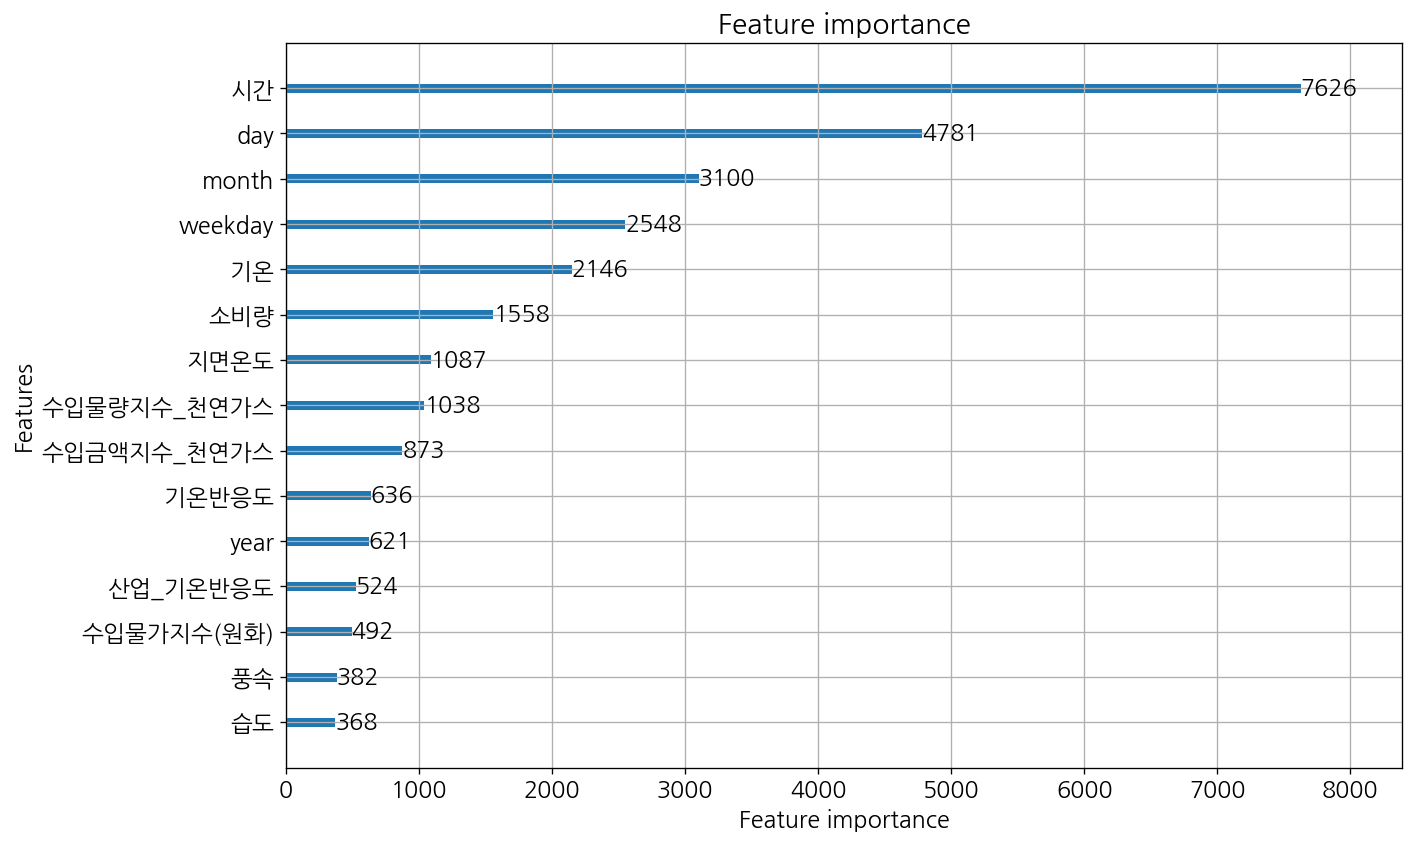

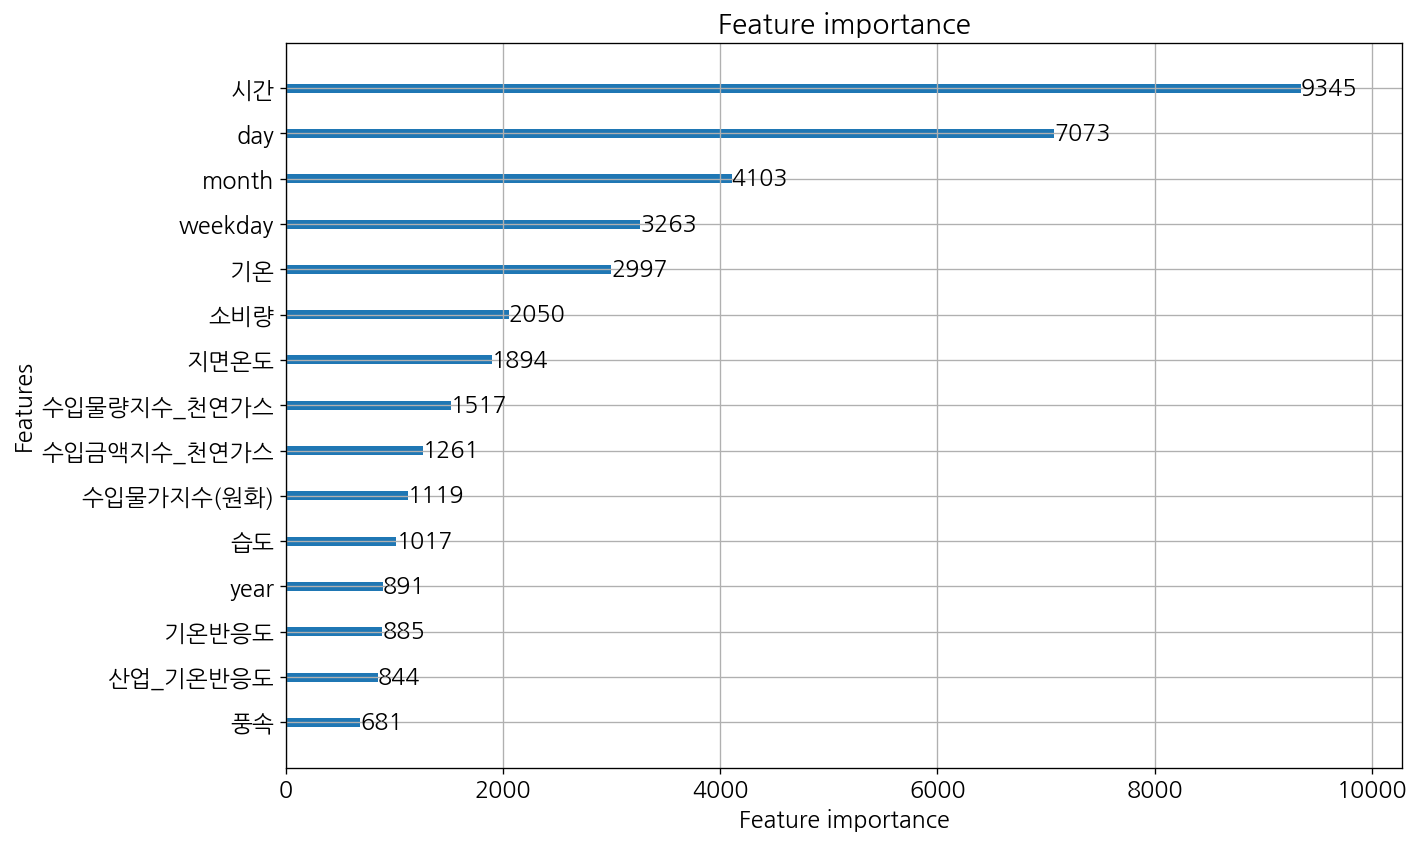

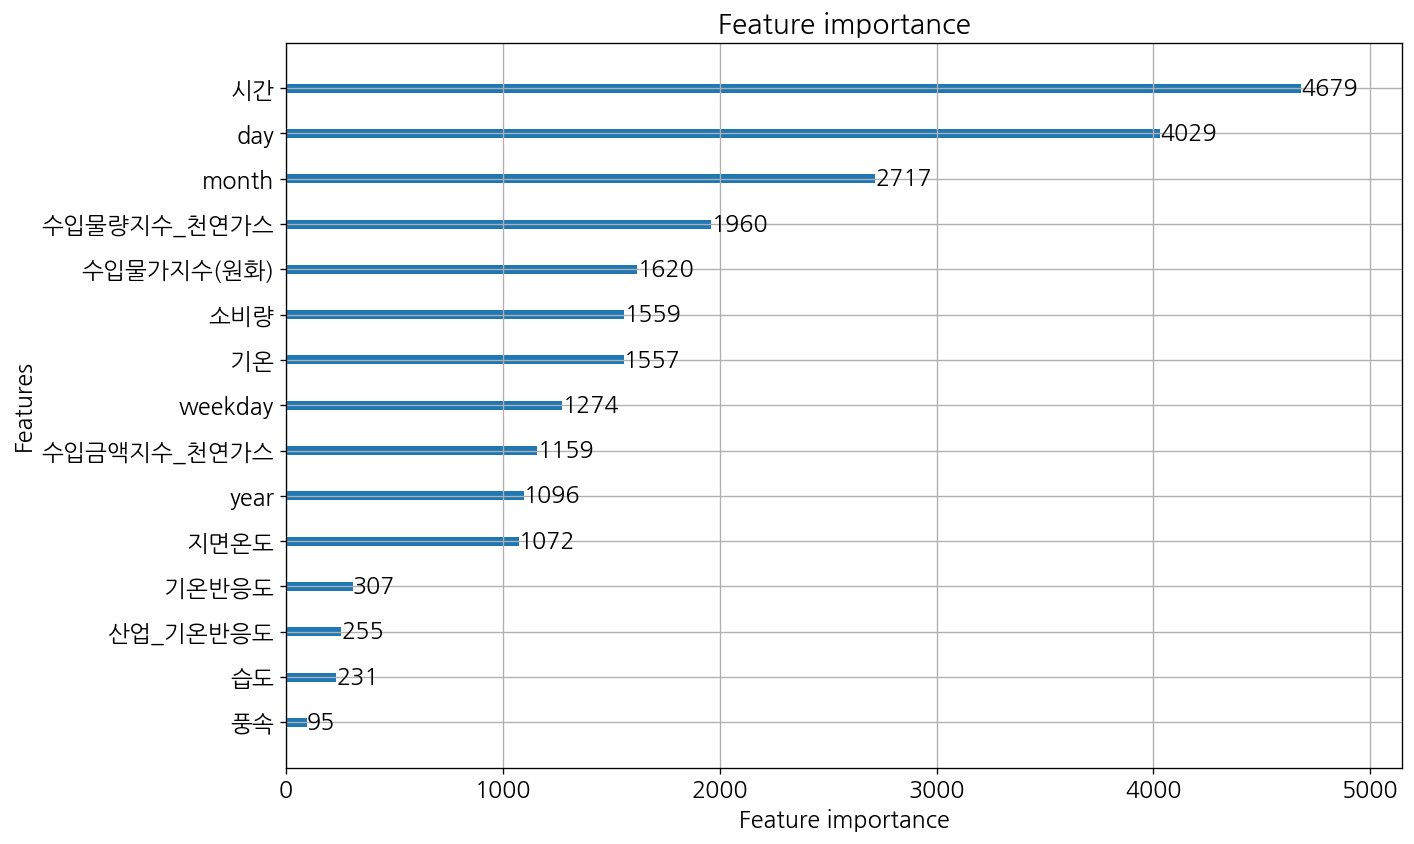

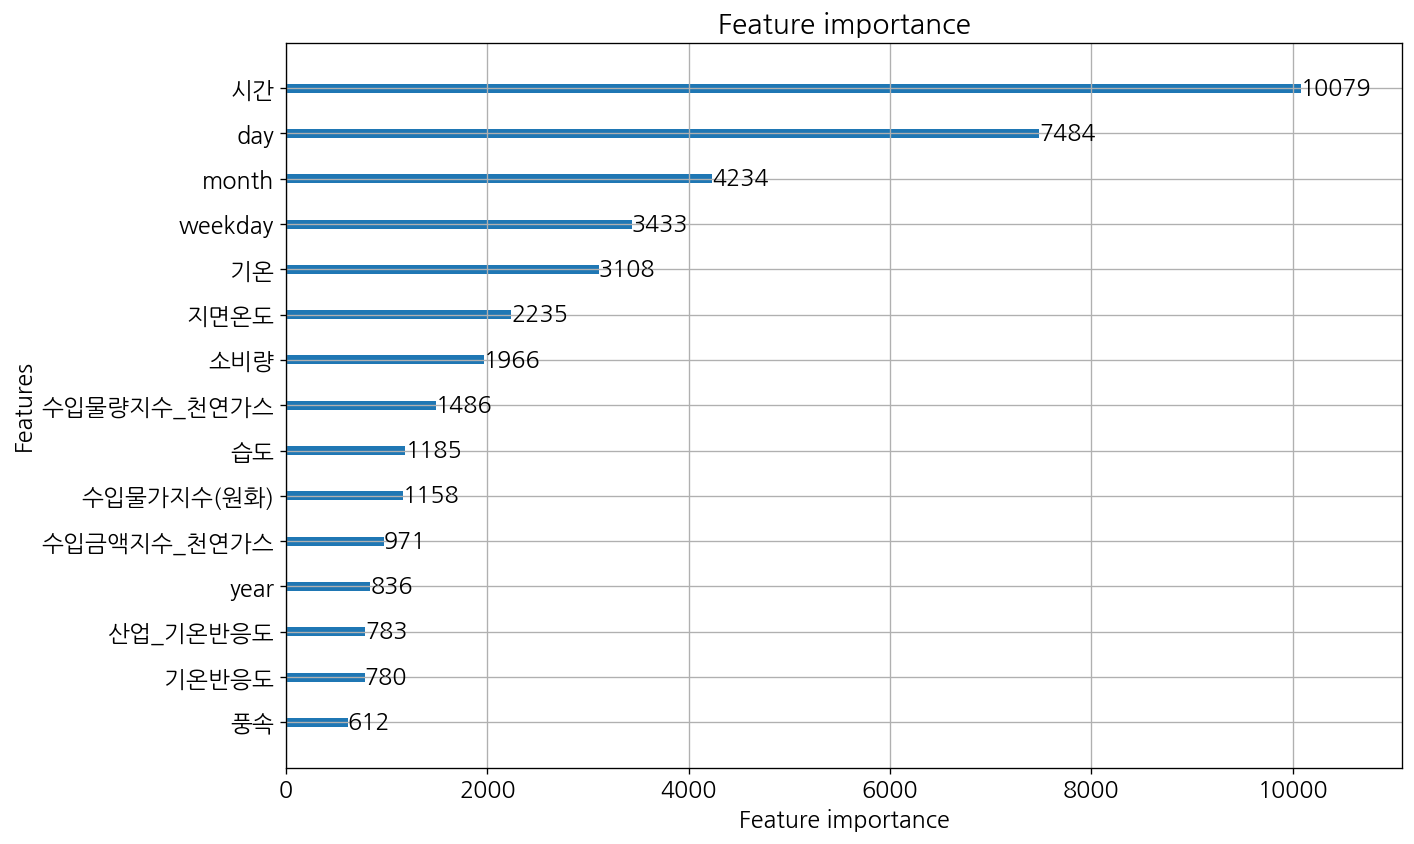

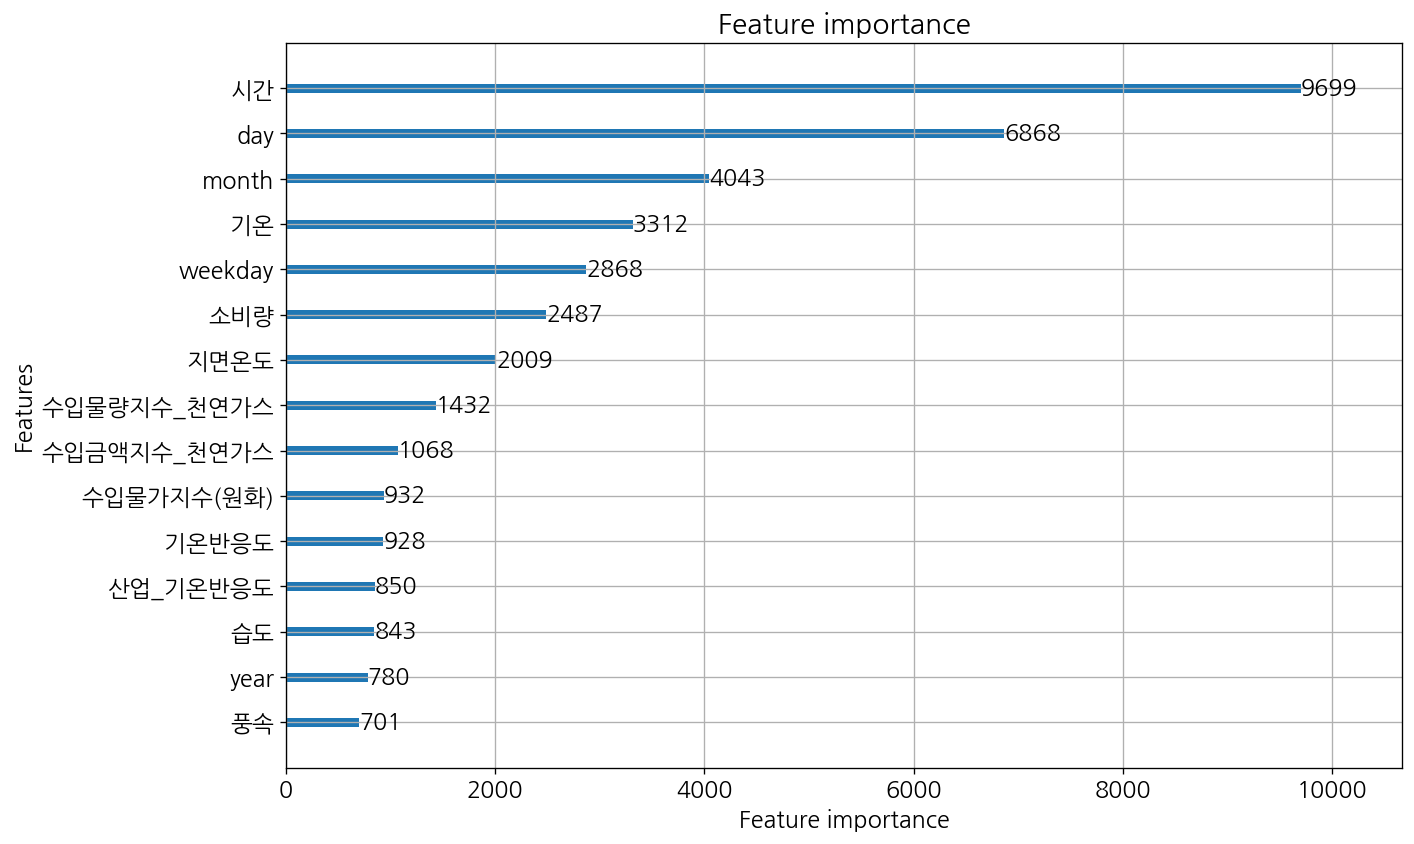

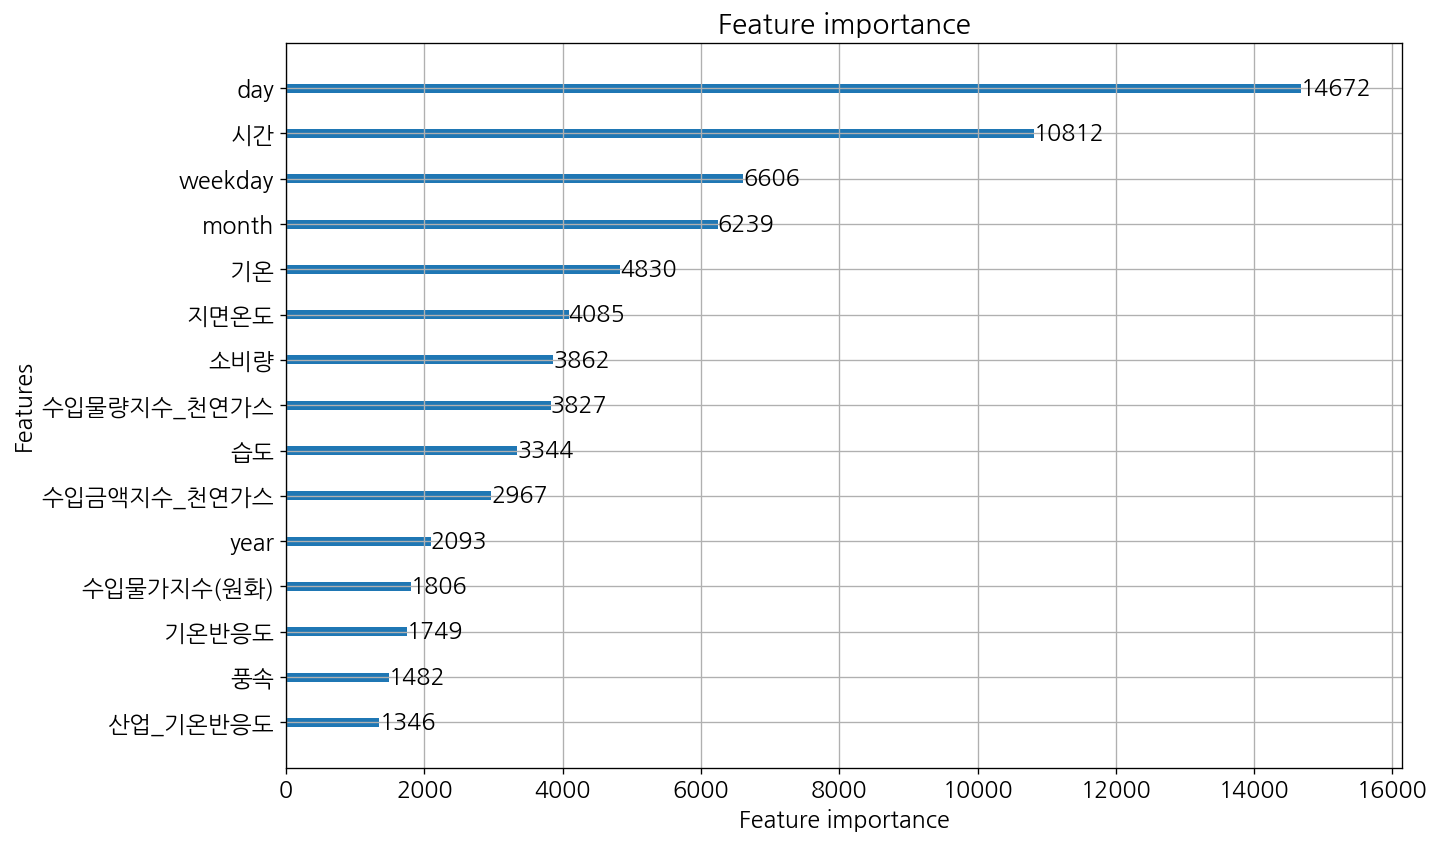

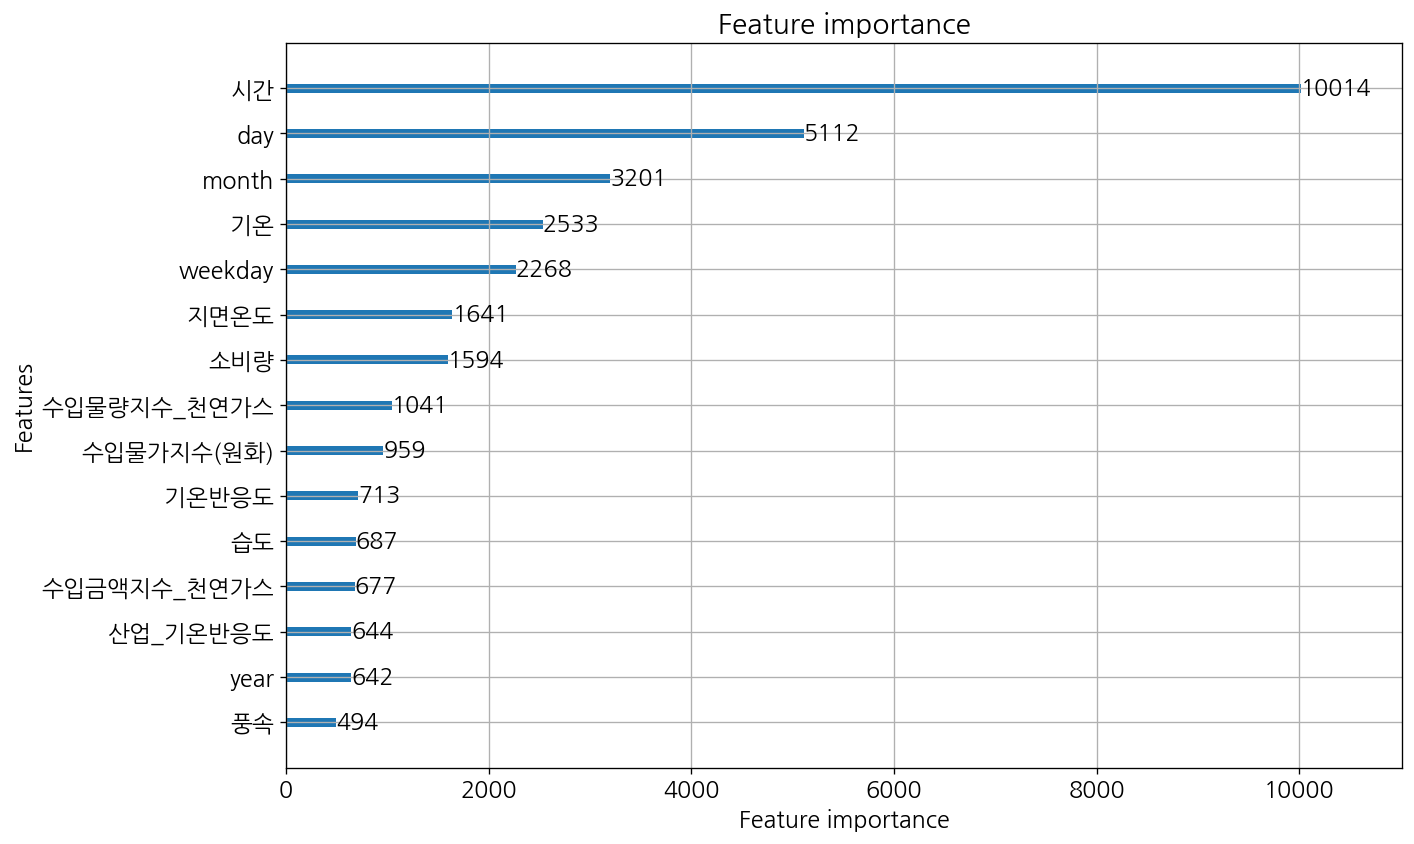

In [388]:
from lightgbm import plot_importance
for kind in range(7):
    plot_importance(model_dict[f'{kind}_model'], max_num_features=20)

In [414]:
sub.to_csv('모든변수추가_난방지수제거_standardscale_시간_numeric.csv', index = False)

In [ ]:
total = total_
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

In [ ]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective' : 'regression',
    'metric' : 'mae',
    'seed' : 42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 242.409
[40]	valid_0's l1: 174.779
[60]	valid_0's l1: 158.333
[80]	valid_0's l1: 152.604
[100]	valid_0's l1: 149.907
[120]	valid_0's l1: 148.328
[140]	valid_0's l1: 147.175
[160]	valid_0's l1: 146.4
[180]	valid_0's l1: 145.825
[200]	valid_0's l1: 145.031
Early stopping, best iteration is:
[194]	valid_0's l1: 144.982


# lgbm 하이퍼파라미터 튜닝


In [ ]:
# 베이지안 최적화를 수행하기 위한 함수 설정
def LGB_cv(n_estimators, max_depth, num_leaves, subsample, min_child_weight, feature_fraction, reg_alpha, reg_lambda) :  
    model = lgb.LGBMRegressor(random_state = 42,
                              n_jobs = -1 ,
                              n_estimators = int(n_estimators),
                              learning_rate = 0.01, #learning_rate,
                              max_depth = int(max_depth),
                              num_leaves = int(num_leaves),
                              subsample = subsample,
                              min_child_weight = min_child_weight,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              feature_fraction = feature_fraction,    # 매 iteraction마다 feature의 80%로 랜덤하게 구성한다. 과적합 방지로 사용
                              )
    model.fit(X_train, y_train, verbose=False)
    # 예측값 출력
    y_pred = model.predict(X_val)
    # metric 계산
    NMAE = nmae_values(y_val, y_pred) * -1
               
    return NMAE

In [ ]:
def train_val_test(X, pbounds) :
  global X_train, y_train, X_val, y_val
  train_years = [2013,2014,2015,2016,2017]
  test_years = [2018]

  train = X[X['year'].isin(train_years)]
  test = X[X['year'].isin(test_years)]
  features = ['구분', 'month', 'day', 'weekday', '시간']
  train_x = train[features]
  train_y = train['공급량']

  test_x = test[features]
  test_y = test['공급량']

  result = pd.DataFrame()
  result_nmae = []

  
  for j in train['구분'].unique() :
  # for j in range(0, 1) :
    result_ = []
    result_nmae_ = []
    train_ = train[train['구분'] == j].reset_index(drop = True)
    test_ = test[test['구분'] == j].reset_index(drop = True)
    test_y_ = test_['공급량']
    test_ = test_[features]
    n = 1
    for val_year in range(2014, 2018) :
      tr_years = [i for i in train_years if i < val_year]
      val_years = [val_year]
      
      X_train = train_[train_['year'].isin(tr_years)].reset_index(drop = True)
      X_val = train_[train_['year'].isin(val_years)].reset_index(drop = True)

      print("구분 {}의 {}번째 교차검증".format(j, n))
      print("Train year :", tr_years, "Validation year :", val_years)

      y_train = X_train['공급량'].reset_index(drop = True)
      y_val = X_val['공급량'].reset_index(drop = True)

      X_train = X_train[features]
      X_val = X_val[features]

      # Bayesian Optimization
      bo = BayesianOptimization(f=LGB_cv, pbounds=pbounds, verbose=2, random_state = 42)   # X_train, y_train으로 학습 
      bo.maximize(init_points=3, n_iter=7) #, acq='ei', xi=0.01)       # 최대화 과정 수행

      # 최적화된 값들로 모델 학습
      fit_model = lgb.LGBMRegressor(random_state = 42,
                                    n_jobs = -1,
                                    learning_rate = 0.01, #bo.max['params']['learning_rate'],
                                    num_leaves = int(bo.max['params']['num_leaves']),
                                    max_depth = int(bo.max['params']['max_depth']),
                                    min_child_weight = bo.max['params']['min_child_weight'],
                                    n_estimators = int(bo.max['params']['n_estimators']),
                                    subsample = bo.max['params']['subsample'],
                                    feature_fraction = bo.max['params']['feature_fraction'],
                                    reg_alpha = bo.max['params']['reg_alpha'],
                                    reg_lambda = bo.max['params']['reg_lambda']
                                    )

      fit_model.fit(X_train, y_train)

      y_pred = fit_model.predict(test_)  
      df = pd.DataFrame(y_pred, columns = ['predict'])
      df['true'] = test_y_.reset_index(drop = True)
      # display(df.head())
      df.plot()
      plt.legend()
      plt.show()

      print('{}번째 교차검증 최적화 하이퍼파라미터 :'.format(n), fit_model)
      print('{}번째 교차검증 최적화된 NMAE값 : {}'.format(n, nmae_values(test_y_, y_pred)))
      # print(bo.max)
      result_.append(bo.max)
      result_nmae_.append(nmae_values(test_y_, y_pred))
      n += 1

    for k in range(len(result_)) :
      for key, value in result_[k]['params'].items() :
        # print(key, value)
        if key == 'max_depth' :
          result_[k]['params'][key] = int(round(value, 0))
        elif key == 'n_estimators' :
          result_[k]['params'][key] = int(round(value, 0))
        elif key == 'num_leaves' :
          result_[k]['params'][key] = int(round(value, 0))
        # print(key, value)

    result_ = pd.DataFrame(result_)
    result_.columns = ['nmae_{}'.format(j), 'params_{}'.format(j)]
    result = pd.concat([result, result_], axis = 1)
    result_nmae.append(result_nmae_)
    print('교차검증 NMAE 평균 : ', np.mean(result_nmae_))
  

  return result

구분 0의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2769   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|  2        | -0.2641   |  0.635    |  64.31    |  0.4215   |  9.699e+0 |  84.08    |  0.2102   |  0.18     |  0.51     |
|  3        | -0.2769   |  0.3708   |  48.18    |  8.645    |  2.913e+0 |  63.13    |  0.1381   |  0.2892   |  0.6198   |
|  4        | -0.9325   |  0.6486   |  89.51    |  7.527    |  15.55    |  11.08    |  0.8505   |  0.487    |  0.722    |
|  5        | -0.2395   |  0.99     |  2.0      |  20.0     |  4.387e+0 |  100.0    |  0.0      |  0.99     |  0.4      |
|  6        | -0.2049   |  0.7641   |  4.43     |  1.415    |  8.188e+0 |  96.06    | 

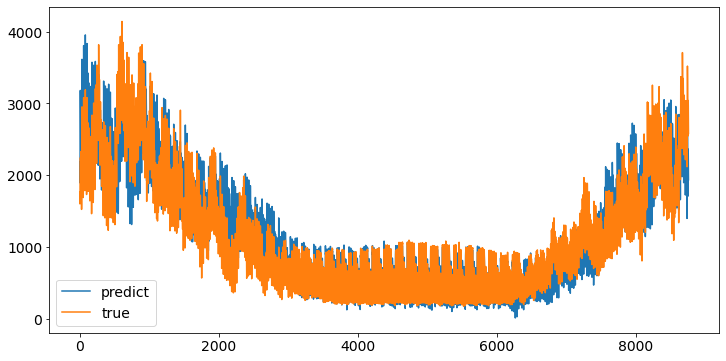

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7640843568989164, importance_type='split',
              learning_rate=0.01, max_depth=4, min_child_samples=20,
              min_child_weight=1.4149706935118045, min_split_gain=0.0,
              n_estimators=8187, n_jobs=-1, num_leaves=96, objective=None,
              random_state=42, reg_alpha=0.32067437452134145,
              reg_lambda=0.3349260476305817, silent=True,
              subsample=0.6976256783022854, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.17064337108498545
구분 0의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2247   |  0.4333  

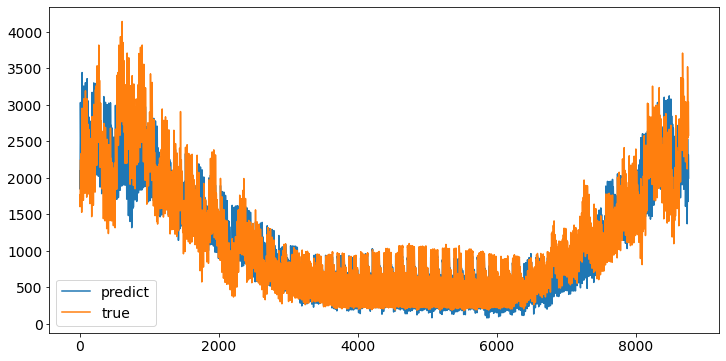

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=7103,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.1410659201072258
구분 0의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2123   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|  2     

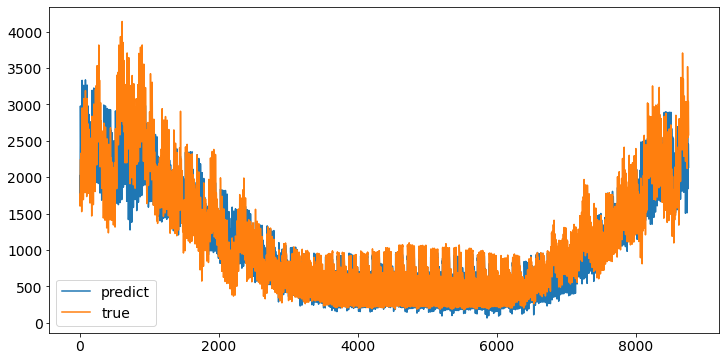

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8483,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.1333442061969971
구분 0의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1919   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
| 

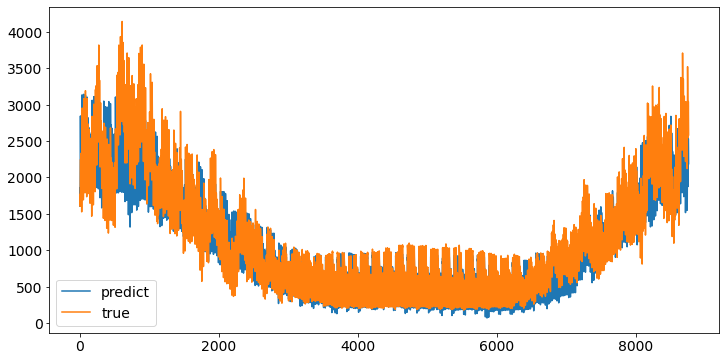

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8474,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.12952739830094445
교차검증 NMAE 평균 :  0.1436452239225382
구분 1의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.3234   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575 

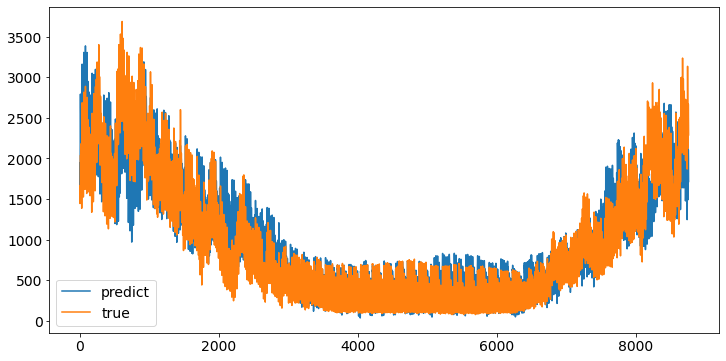

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7868501080548491, importance_type='split',
              learning_rate=0.01, max_depth=89, min_child_samples=20,
              min_child_weight=11.83463148970623, min_split_gain=0.0,
              n_estimators=8717, n_jobs=-1, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.4507014410014579,
              reg_lambda=0.48564365412639415, silent=True,
              subsample=0.6501605927240282, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.19192069947130416
구분 1의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2838   |  0.4333  

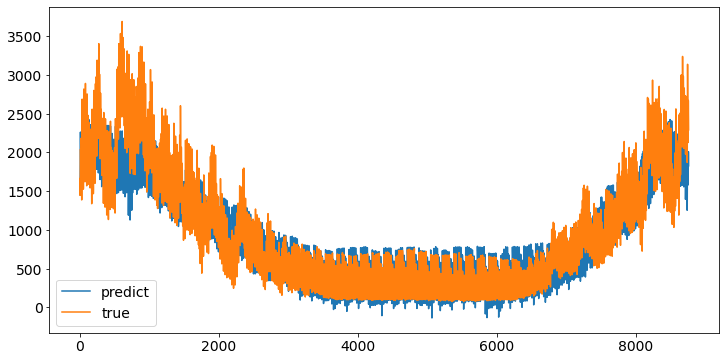

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=2, min_child_samples=20,
              min_child_weight=0.01, min_split_gain=0.0, n_estimators=7001,
              n_jobs=-1, num_leaves=100, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.20252379115597932
구분 1의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.25     |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|  2  

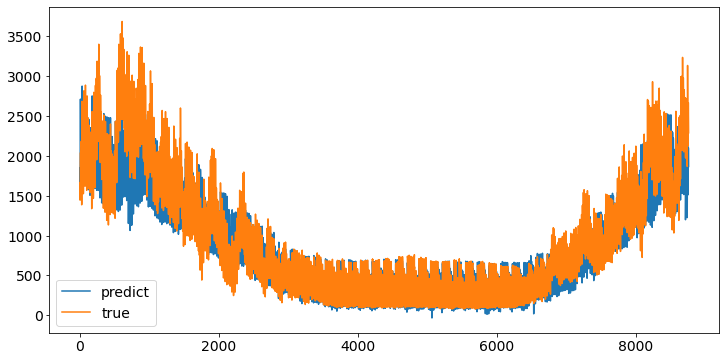

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=0.01, min_split_gain=0.0, n_estimators=7007,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.1512863567139087
구분 1의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2386   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|  2

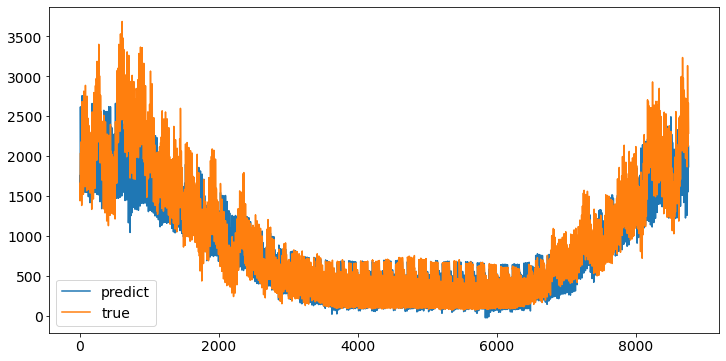

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8557,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.1462298304641315
교차검증 NMAE 평균 :  0.17299016945133092
구분 2의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1946   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575 

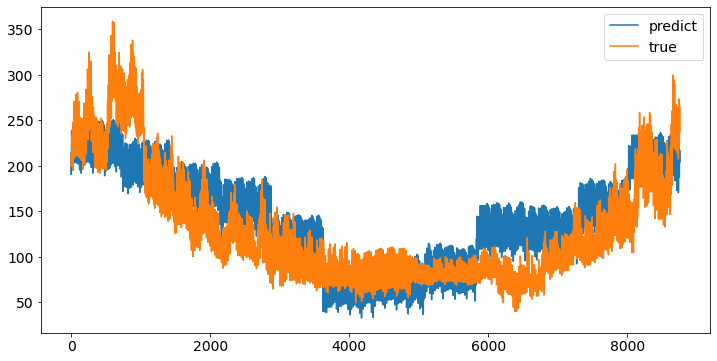

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.3707755962339886, importance_type='split',
              learning_rate=0.01, max_depth=48, min_child_samples=20,
              min_child_weight=8.644580922655893, min_split_gain=0.0,
              n_estimators=2913, n_jobs=-1, num_leaves=63, objective=None,
              random_state=42, reg_alpha=0.1380989220455214,
              reg_lambda=0.28922320204986596, silent=True,
              subsample=0.619817105976215, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.25365020156527035
구분 2의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2691   |  0.4333   

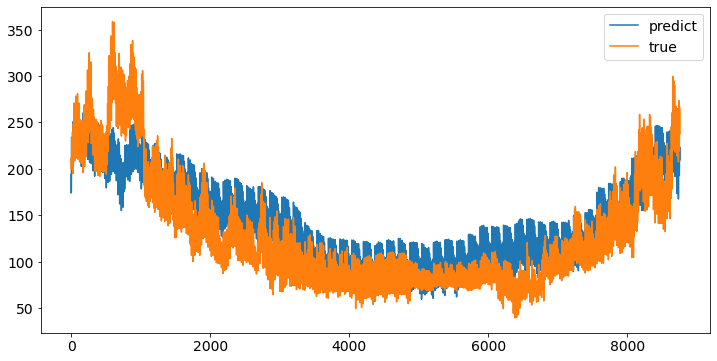

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.5024704302949854, importance_type='split',
              learning_rate=0.01, max_depth=3, min_child_samples=20,
              min_child_weight=2.492663156861183, min_split_gain=0.0,
              n_estimators=4320, n_jobs=-1, num_leaves=98, objective=None,
              random_state=42, reg_alpha=0.24764820476117447,
              reg_lambda=0.010152903506155622, silent=True,
              subsample=0.661507006951654, subsample_for_bin=200000,
              subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.2058442247119601
구분 2의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1738   |  0.4

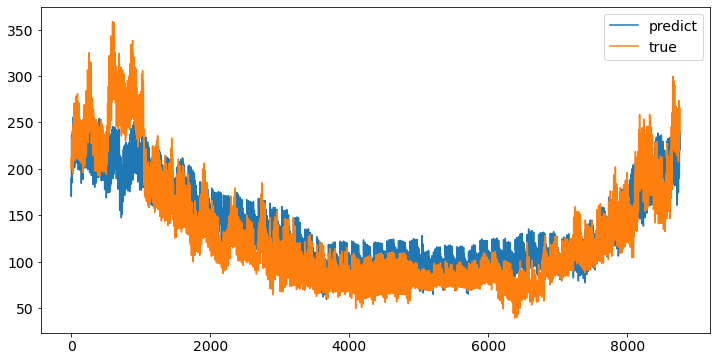

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9793824937862193, importance_type='split',
              learning_rate=0.01, max_depth=3, min_child_samples=20,
              min_child_weight=17.458834330083633, min_split_gain=0.0,
              n_estimators=6544, n_jobs=-1, num_leaves=99, objective=None,
              random_state=42, reg_alpha=0.6422052813351043,
              reg_lambda=0.21970654381209853, silent=True,
              subsample=0.8550740357325171, subsample_for_bin=200000,
              subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.15813537707666175
구분 2의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.09874 

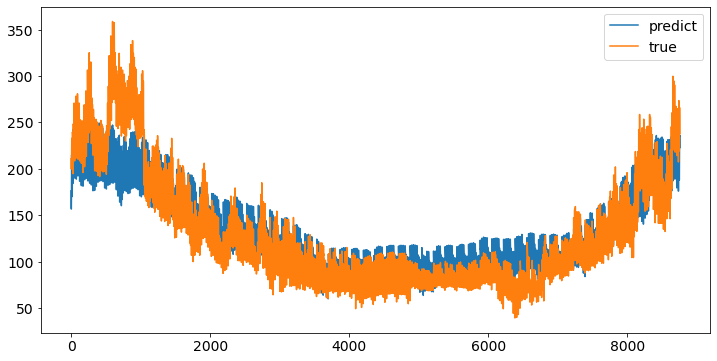

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7554411681623602, importance_type='split',
              learning_rate=0.01, max_depth=87, min_child_samples=20,
              min_child_weight=6.085068518487259, min_split_gain=0.0,
              n_estimators=3759, n_jobs=-1, num_leaves=7, objective=None,
              random_state=42, reg_alpha=0.6595429358197304,
              reg_lambda=0.9772720500575169, silent=True,
              subsample=0.7506692072830734, subsample_for_bin=200000,
              subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.1408688826605253
교차검증 NMAE 평균 :  0.1896246715036044
구분 3의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1     

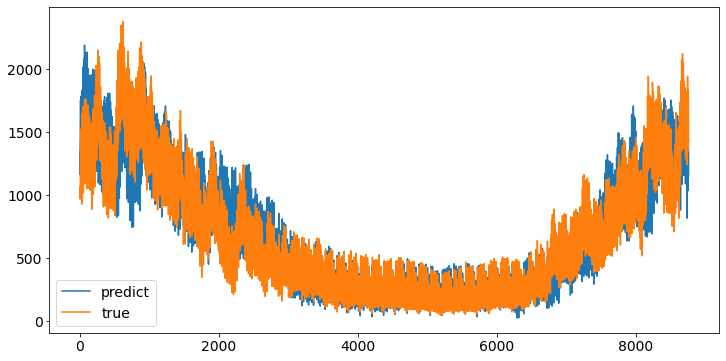

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7965856299937562, importance_type='split',
              learning_rate=0.01, max_depth=9, min_child_samples=20,
              min_child_weight=0.7541816414318554, min_split_gain=0.0,
              n_estimators=7763, n_jobs=-1, num_leaves=98, objective=None,
              random_state=42, reg_alpha=0.621223209999113,
              reg_lambda=0.2625808359407913, silent=True,
              subsample=0.8141814155134408, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.16378726378174116
구분 3의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2458   |  0.4333   |

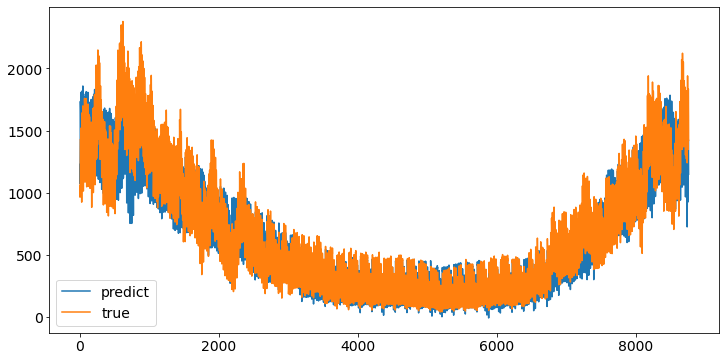

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8525,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.14467826923443322
구분 3의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2476   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|  2   

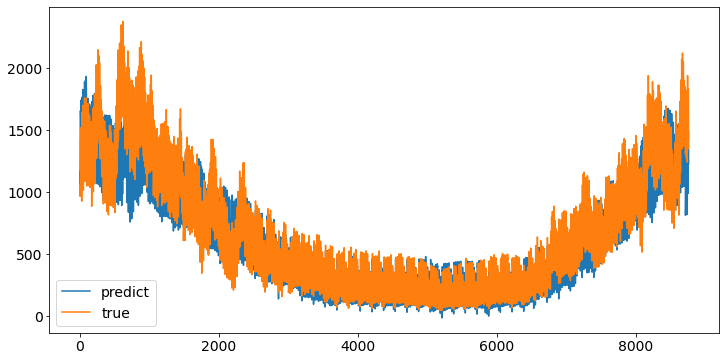

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8530,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.1412066343283154
구분 3의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2216   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
| 

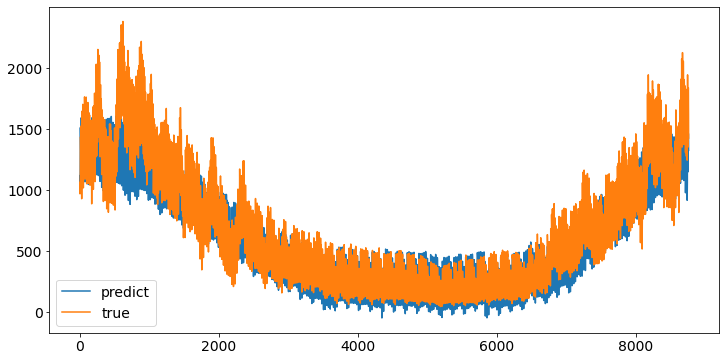

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=2, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8050,
              n_jobs=-1, num_leaves=100, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True,
              subsample=0.8567257718953698, subsample_for_bin=200000,
              subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.17108994848466474
교차검증 NMAE 평균 :  0.15519052895728863
구분 4의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2854   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  

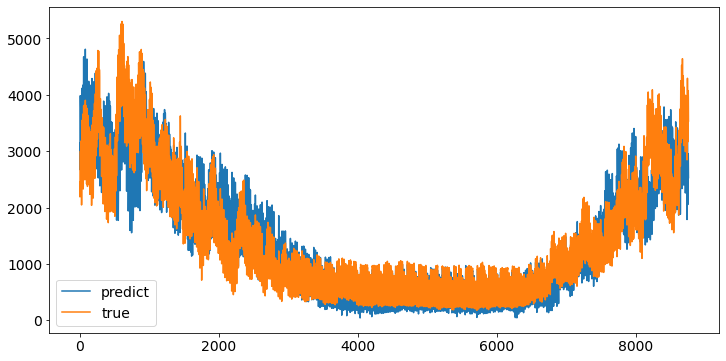

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.985727346009705, importance_type='split',
              learning_rate=0.01, max_depth=6, min_child_samples=20,
              min_child_weight=15.487003676148854, min_split_gain=0.0,
              n_estimators=6983, n_jobs=-1, num_leaves=95, objective=None,
              random_state=42, reg_alpha=0.4895346232546841,
              reg_lambda=0.2999025075266935, silent=True,
              subsample=0.8357261796656331, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.175786166378902
구분 4의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2472   |  0.4333   |  

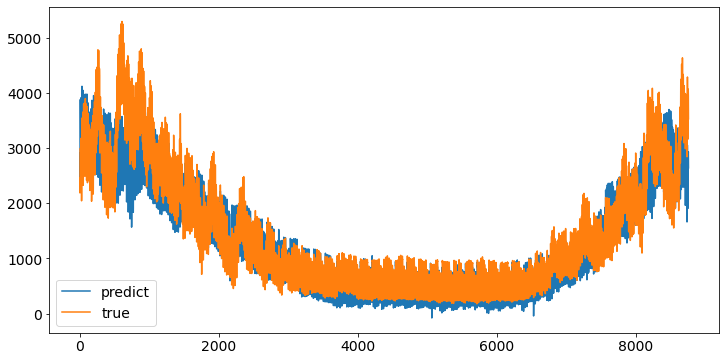

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8533,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.16102688796752493
구분 4의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2381   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|  2   

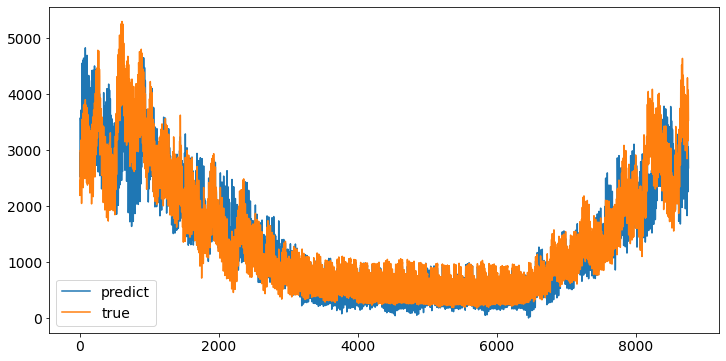

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=77, min_child_samples=20,
              min_child_weight=18.871794048136902, min_split_gain=0.0,
              n_estimators=6989, n_jobs=-1, num_leaves=100, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=3.2266374713591684e-12,
              silent=True, subsample=0.4, subsample_for_bin=200000,
              subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.1673322789804408
구분 4의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2126   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19

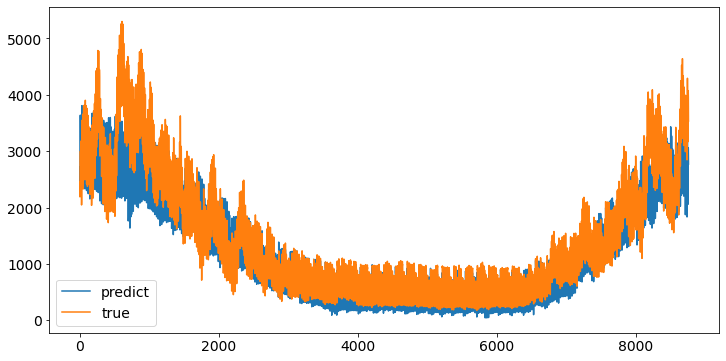

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8509,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.15407102100641334
교차검증 NMAE 평균 :  0.16455408858332027
구분 5의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1718   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575

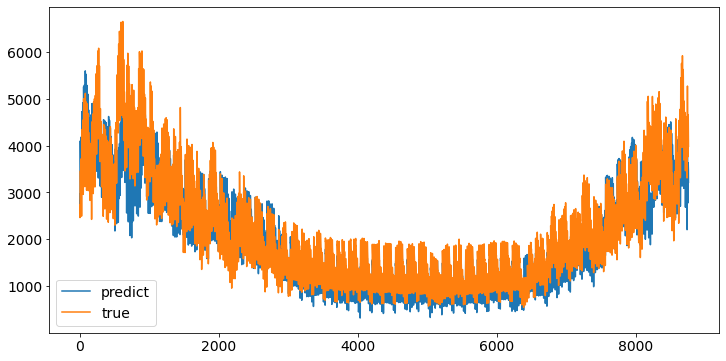

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9387794933071718, importance_type='split',
              learning_rate=0.01, max_depth=80, min_child_samples=20,
              min_child_weight=14.90316567798102, min_split_gain=0.0,
              n_estimators=8573, n_jobs=-1, num_leaves=6, objective=None,
              random_state=42, reg_alpha=0.05512207613484861,
              reg_lambda=0.7593373507032539, silent=True,
              subsample=0.4213006495235343, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.15042341662555858
구분 5의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.169    |  0.4333   

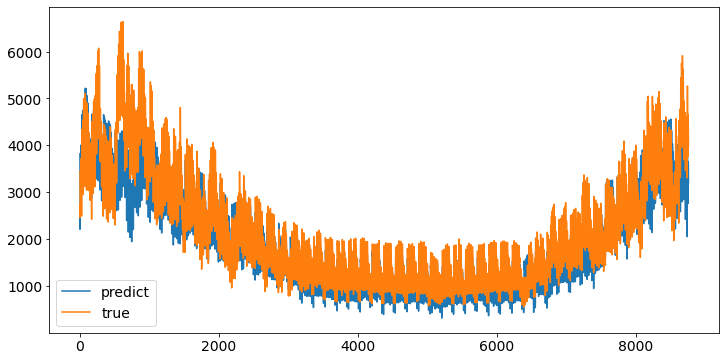

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9387794933071718, importance_type='split',
              learning_rate=0.01, max_depth=80, min_child_samples=20,
              min_child_weight=14.90316567798102, min_split_gain=0.0,
              n_estimators=8573, n_jobs=-1, num_leaves=6, objective=None,
              random_state=42, reg_alpha=0.05512207613484861,
              reg_lambda=0.7593373507032539, silent=True,
              subsample=0.4213006495235343, subsample_for_bin=200000,
              subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.14334853326057428
구분 5의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1572   |  0.4

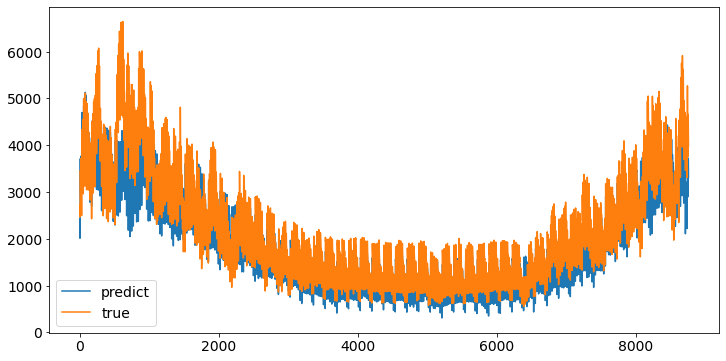

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9387794933071718, importance_type='split',
              learning_rate=0.01, max_depth=80, min_child_samples=20,
              min_child_weight=14.90316567798102, min_split_gain=0.0,
              n_estimators=8573, n_jobs=-1, num_leaves=6, objective=None,
              random_state=42, reg_alpha=0.05512207613484861,
              reg_lambda=0.7593373507032539, silent=True,
              subsample=0.4213006495235343, subsample_for_bin=200000,
              subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.14518609823259412
구분 5의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1504   

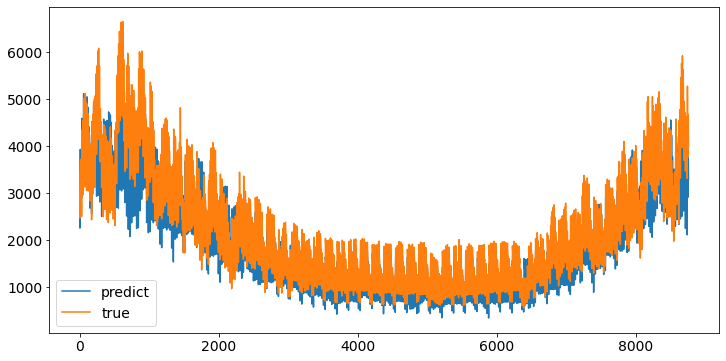

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7868501080548491, importance_type='split',
              learning_rate=0.01, max_depth=89, min_child_samples=20,
              min_child_weight=11.83463148970623, min_split_gain=0.0,
              n_estimators=8717, n_jobs=-1, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.4507014410014579,
              reg_lambda=0.48564365412639415, silent=True,
              subsample=0.6501605927240282, subsample_for_bin=200000,
              subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.14696489772141333
교차검증 NMAE 평균 :  0.14648073646003507
구분 6의 1번째 교차검증
Train year : [2013] Validation year : [2014]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1 

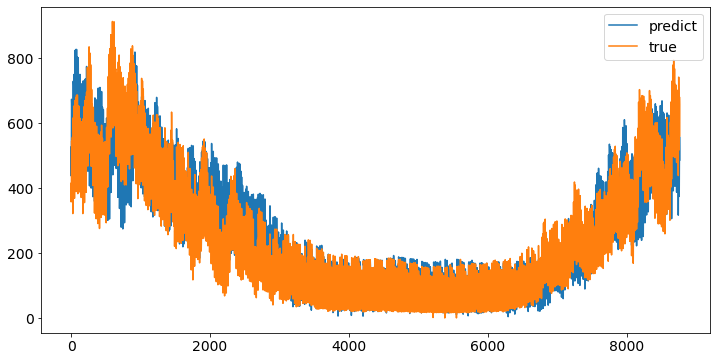

1번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.8291992857228637, importance_type='split',
              learning_rate=0.01, max_depth=84, min_child_samples=20,
              min_child_weight=2.972759566592051, min_split_gain=0.0,
              n_estimators=4403, n_jobs=-1, num_leaves=90, objective=None,
              random_state=42, reg_alpha=0.1451356755811707,
              reg_lambda=0.6202849263725424, silent=True,
              subsample=0.42008357039903843, subsample_for_bin=200000,
              subsample_freq=0)
1번째 교차검증 최적화된 NMAE값 : 0.16315898481218538
구분 6의 2번째 교차검증
Train year : [2013, 2014] Validation year : [2015]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2631   |  0.4333  

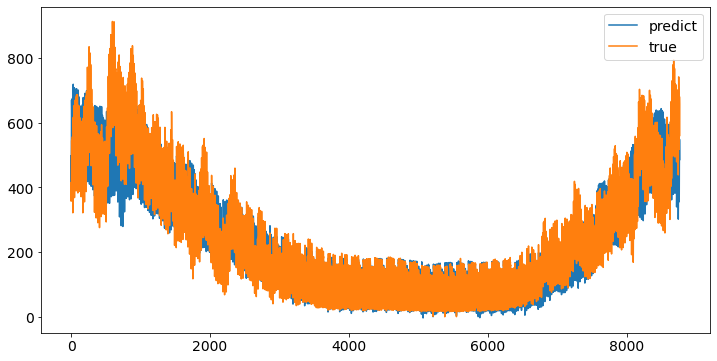

2번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7554411681623602, importance_type='split',
              learning_rate=0.01, max_depth=87, min_child_samples=20,
              min_child_weight=6.085068518487259, min_split_gain=0.0,
              n_estimators=3759, n_jobs=-1, num_leaves=7, objective=None,
              random_state=42, reg_alpha=0.6595429358197304,
              reg_lambda=0.9772720500575169, silent=True,
              subsample=0.7506692072830734, subsample_for_bin=200000,
              subsample_freq=0)
2번째 교차검증 최적화된 NMAE값 : 0.1405066224377235
구분 6의 3번째 교차검증
Train year : [2013, 2014, 2015] Validation year : [2016]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2487   |  0.433

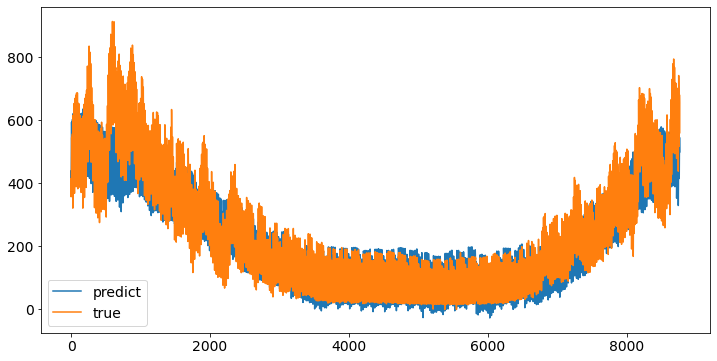

3번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=2, min_child_samples=20,
              min_child_weight=0.01, min_split_gain=0.0, n_estimators=7940,
              n_jobs=-1, num_leaves=100, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.0, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
3번째 교차검증 최적화된 NMAE값 : 0.17768681254474528
구분 6의 4번째 교차검증
Train year : [2013, 2014, 2015, 2016] Validation year : [2017]
|   iter    |  target   | featur... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2254   |  0.4333   |  85.66    |  14.64    |  5.987e+0 |  19.82    |  0.1544   |  0.0575   |  0.9197   |
|

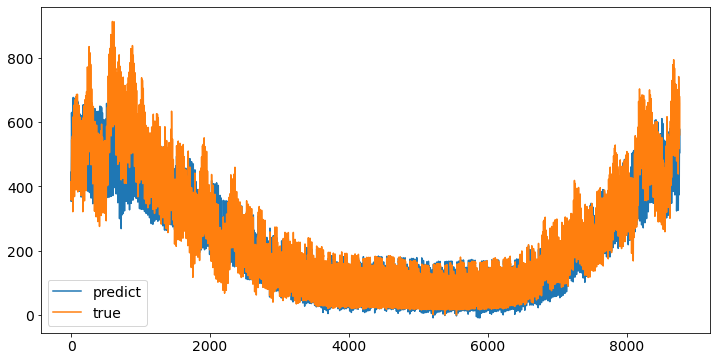

4번째 교차검증 최적화 하이퍼파라미터 : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.99, importance_type='split',
              learning_rate=0.01, max_depth=90, min_child_samples=20,
              min_child_weight=20.0, min_split_gain=0.0, n_estimators=8558,
              n_jobs=-1, num_leaves=5, objective=None, random_state=42,
              reg_alpha=0.99, reg_lambda=0.99, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)
4번째 교차검증 최적화된 NMAE값 : 0.13340151056637492
교차검증 NMAE 평균 :  0.15368848259025727


In [ ]:
# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (2, 90),
          #  'learning_rate': 0.01,
           'n_estimators': (1, 10000),
           'min_child_weight': (0.01, 20),
           'subsample': (0.4, 1),
           'num_leaves' : (5, 100),
           'feature_fraction' : (0.1, 0.99),
           'reg_alpha' : (0, 0.99),
           'reg_lambda' : (0, 0.99)
              }

result = train_val_test(total, pbounds)

In [ ]:
result

,nmae_0,params_0,nmae_1,params_1,nmae_2,params_2,nmae_3,params_3,nmae_4,params_4,nmae_5,params_5,nmae_6,params_6
0,-0.204932,"{'feature_fraction': 0.7640843568989164, 'max_...",-0.228813,"{'feature_fraction': 0.7868501080548491, 'max_...",-0.194499,"{'feature_fraction': 0.3707755962339886, 'max_...",-0.169690,"{'feature_fraction': 0.7965856299937562, 'max_...",-0.184259,"{'feature_fraction': 0.985727346009705, 'max_d...",-0.130782,"{'feature_fraction': 0.9387794933071718, 'max_...",-0.158073,"{'feature_fraction': 0.8291992857228637, 'max_..."
1,-0.153941,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.229937,"{'feature_fraction': 0.99, 'max_depth': 2, 'mi...",-0.265229,"{'feature_fraction': 0.5024704302949854, 'max_...",-0.167792,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.158805,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.120855,"{'feature_fraction': 0.9387794933071718, 'max_...",-0.160323,"{'feature_fraction': 0.7554411681623602, 'max_..."
2,-0.141563,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.154922,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.159430,"{'feature_fraction': 0.9793824937862193, 'max_...",-0.163060,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.163457,"{'feature_fraction': 0.99, 'max_depth': 77, 'm...",-0.112335,"{'feature_fraction': 0.9387794933071718, 'max_...",-0.199825,"{'feature_fraction': 0.99, 'max_depth': 2, 'mi..."
3,-0.121104,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.143970,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.086273,"{'feature_fraction': 0.7554411681623602, 'max_...",-0.172616,"{'feature_fraction': 0.99, 'max_depth': 2, 'mi...",-0.130705,"{'feature_fraction': 0.99, 'max_depth': 90, 'm...",-0.118611,"{'feature_fraction': 0.7868501080548491, 'max_...",-0.130108,"{'feature_fraction': 0.99, 'max_depth': 90, 'm..."


In [ ]:
result['params_0'].iloc[3]

{'feature_fraction': 0.8322589525974274,
 'max_depth': 4.942519460534547,
 'min_child_weight': 4.16458921439483,
 'n_estimators': 8160.313131451922,
 'num_leaves': 9.83613006050016,
 'reg_alpha': 0.07773102844857185,
 'reg_lambda': 0.2690508592079099,
 'subsample': 0.4573499618865127}

In [ ]:
pd.DataFrame(result[0])

,target,params
0,-0.203267,"{'feature_fraction': 0.9265833599747607, 'max_..."
1,-0.159451,"{'feature_fraction': 0.9265833599747607, 'max_..."
2,-0.144066,"{'feature_fraction': 0.9265833599747607, 'max_..."
3,-0.145843,"{'feature_fraction': 0.862033448883198, 'max_d..."


In [ ]:
# result_mape = []
# for i in result :
#     result_mape.append(list(i.items())[0][1] * -1)
    
# print('MAPE 값을 최소화하는 하이퍼파라미터')
# print(pd.DataFrame(result_mape, columns = ['유입량']).sort_values(by = '유입량').iloc[0].name, '번째 파라미터')
# print(result[pd.DataFrame(result_mape, columns = ['유입량']).sort_values(by = '유입량').iloc[0].name]['params'])

MAPE 값을 최소화하는 하이퍼파라미터
13 번째 파라미터
{'colsample_bytree': 0.99, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 0.9215786233997231, 'n_estimators': 6038, 'reg_alpha': 0.36516267277203135, 'reg_lambda': 0.01, 'subsample': 0.7611671326691636}


In [ ]:
result

[[{'params': {'feature_fraction': 0.6349923604514558,
    'max_depth': 64,
    'min_child_weight': 0.4214840409730909,
    'n_estimators': 9699,
    'num_leaves': 84,
    'reg_alpha': 0.2102157195714934,
    'reg_lambda': 0.18000671753502961,
    'subsample': 0.5100427059120604},
   'target': -0.22025773710686317},
  {'params': {'feature_fraction': 0.6349923604514558,
    'max_depth': 64,
    'min_child_weight': 0.4214840409730909,
    'n_estimators': 9699,
    'num_leaves': 84,
    'reg_alpha': 0.2102157195714934,
    'reg_lambda': 0.18000671753502961,
    'subsample': 0.5100427059120604},
   'target': -0.22025773710686317},
  {'params': {'feature_fraction': 0.6349923604514558,
    'max_depth': 64,
    'min_child_weight': 0.4214840409730909,
    'n_estimators': 9699,
    'num_leaves': 84,
    'reg_alpha': 0.2102157195714934,
    'reg_lambda': 0.18000671753502961,
    'subsample': 0.5100427059120604},
   'target': -0.22025773710686317},
  {'params': {'feature_fraction': 0.6349923604514

In [ ]:
tr_year = [i for i in a if i < val]
tr_year

[2013, 2014]

# pycaret 사용

In [ ]:
from pycaret.regression import *

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간', '공급량']
total_ = total[features]

reg = setup(data = total_, target = '공급량')

,Description,Value
0,session_id,1862
1,Target,공급량
2,Original Data,"(368088, 6)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 28)"


In [ ]:
best_model_5 = compare_models(n_select = 5, sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,91.3498,29459.8194,171.6000,0.9658,0.2463,0.2418,93.093
et,Extra Trees Regressor,99.2793,35205.1756,187.6126,0.9591,0.2403,0.2300,102.193
lightgbm,Light Gradient Boosting Machine,114.9815,37509.0343,193.6397,0.9565,0.4078,0.5315,1.412
dt,Decision Tree Regressor,110.1098,50543.8073,224.7616,0.9413,0.2507,0.2030,1.297
gbr,Gradient Boosting Regressor,198.4034,88922.3440,298.1804,0.8968,0.6192,0.7192,24.083
knn,K Neighbors Regressor,241.0894,133225.5391,364.9845,0.8453,0.5861,1.1977,11.273
ridge,Ridge Regression,333.3774,193874.7453,440.3025,0.7749,0.8262,2.4452,0.080
br,Bayesian Ridge,333.3784,193874.7400,440.3025,0.7749,0.8262,2.4453,0.455
lr,Linear Regression,333.0251,194005.3984,440.4515,0.7747,0.8268,2.4292,0.455
lar,Least Angle Regression,333.5866,194039.8631,440.4881,0.7747,0.8272,2.4545,0.095


In [ ]:
best_model_5

[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=1862, verbose=0, warm_start=False),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1862, verbose=0, warm_start=False),
 LGBMRe

In [ ]:
tuned_top5 = [tune_model(i) for i in best_model_5]

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:50:51
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

# pycaret 사용 - 지역난방

In [ ]:
from pycaret.regression import *

In [ ]:
heat_data

,Unnamed: 0,시간,난방지수,연월일,일시
0,0,0,10695.0,2013-01-01,2013-01-01 00:00:00
1,1,1,10186.0,2013-01-01,2013-01-01 01:00:00
2,2,2,9765.0,2013-01-01,2013-01-01 02:00:00
3,3,3,9468.0,2013-01-01,2013-01-01 03:00:00
4,4,4,9378.0,2013-01-01,2013-01-01 04:00:00
...,...,...,...,...,...
52579,19,19,10267.0,2018-12-31,2018-12-31 19:00:00
52580,20,20,10752.0,2018-12-31,2018-12-31 20:00:00
52581,21,21,11190.0,2018-12-31,2018-12-31 21:00:00
52582,22,22,10962.0,2018-12-31,2018-12-31 22:00:00


In [ ]:
total['연월일'].dt.year

In [ ]:
pd.to_datetime(heat_data['일시']).dt.year

0        2013
1        2013
2        2013
3        2013
4        2013
         ... 
52579    2018
52580    2018
52581    2018
52582    2018
52583    2018
Name: 일시, Length: 52584, dtype: int64

In [ ]:
features = ['시간', 'year', 'month', 'day', 'weekday', '난방지수']
heat_data['year'] = pd.to_datetime(heat_data['일시']).dt.year
heat_data['month'] = pd.to_datetime(heat_data['일시']).dt.month
heat_data['day'] = pd.to_datetime(heat_data['일시']).dt.day
heat_data['weekday'] = pd.to_datetime(heat_data['일시']).dt.weekday
heat_data_ = heat_data[features]

reg = setup(data = heat_data_, target = '난방지수')

,Description,Value
0,session_id,6014
1,Target,난방지수
2,Original Data,"(52584, 6)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(36808, 27)"


In [ ]:
best_model_5 = compare_models(n_select = 5, sort = 'mae')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,162.1032,7.640238e+04,276.3098,0.9912,0.0606,0.0431,11.275
dt,Decision Tree Regressor,214.6722,1.551787e+05,393.5060,0.9821,0.0849,0.0566,0.199
lightgbm,Light Gradient Boosting Machine,307.7248,1.921919e+05,438.3186,0.9778,0.1236,0.0979,0.301
gbr,Gradient Boosting Regressor,573.1599,6.031502e+05,776.5304,0.9304,0.2485,0.2121,2.347
huber,Huber Regressor,831.9732,1.431966e+06,1196.5120,0.8348,0.2960,0.2525,1.501
lr,Linear Regression,837.2587,1.422516e+06,1192.5650,0.8359,0.2988,0.2603,0.377
lar,Least Angle Regression,837.2663,1.422542e+06,1192.5761,0.8359,0.2988,0.2602,0.048
br,Bayesian Ridge,837.2782,1.422517e+06,1192.5654,0.8359,0.2988,0.2603,0.083
ridge,Ridge Regression,837.3074,1.422517e+06,1192.5655,0.8359,0.2988,0.2604,0.038
lasso,Lasso Regression,837.8235,1.422514e+06,1192.5619,0.8359,0.2995,0.2617,0.050


In [ ]:
best_model_5

[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=6014, verbose=0, warm_start=False),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=6014, splitter='best'),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           

In [ ]:
# tuned_top5 = [tune_model(i) for i in best_model_5]
tuned_rf = tune_model(best_model_5[0])

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:40:14
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
# final_lgbm = finalize_model(tuned_lgbm)
final_lgbm = finalize_model(best_model_5[0])

In [ ]:
heat_data_

,시간,year,month,day,weekday,난방지수
0,0,2013,1,1,1,10695.0
1,1,2013,1,1,1,10186.0
2,2,2013,1,1,1,9765.0
3,3,2013,1,1,1,9468.0
4,4,2013,1,1,1,9378.0
...,...,...,...,...,...,...
52579,19,2018,12,31,0,10267.0
52580,20,2018,12,31,0,10752.0
52581,21,2018,12,31,0,11190.0
52582,22,2018,12,31,0,10962.0


In [ ]:
heat_test = heat_data_test.iloc[-2160 :].reset_index(drop = True)
heat_test['year'] = pd.to_datetime(heat_test['일시']).dt.year
heat_test['month'] = pd.to_datetime(heat_test['일시']).dt.month
heat_test['day'] = pd.to_datetime(heat_test['일시']).dt.day
heat_test['weekday'] = pd.to_datetime(heat_test['일시']).dt.weekday
heat_test = heat_test[['시간', 'year', 'month', 'day', 'weekday']]

In [ ]:
predict_model(final_lgbm, heat_test)

,시간,year,month,day,weekday,Label
0,0,2019,1,1,1,8604.28
1,1,2019,1,1,1,8125.70
2,2,2019,1,1,1,7848.99
3,3,2019,1,1,1,7641.61
4,4,2019,1,1,1,7600.03
...,...,...,...,...,...,...
2155,19,2019,3,31,6,3849.73
2156,20,2019,3,31,6,4316.77
2157,21,2019,3,31,6,4419.09
2158,22,2019,3,31,6,4345.08


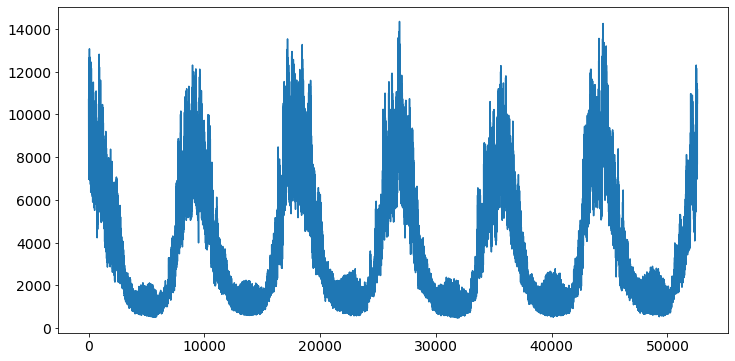

In [ ]:
heat_data_['난방지수'].plot()

In [ ]:
def nmae(true_df, pred_df):
#     target_idx = true_df.iloc[:,0]
#     pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
#     pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
#     true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
#     true = true_df.iloc[:,1].to_numpy()
#     pred = pred_df.iloc[:,1].to_numpy()
    true = true_df.iloc[:].to_numpy()
    pred = pred_df.iloc[:].to_numpy()
    
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [ ]:
nmae(heat_data_test.iloc[-2160 :].reset_index()['난방지수'], predict_model(final_lgbm, heat_test)['Label'])

0.1494722020136485

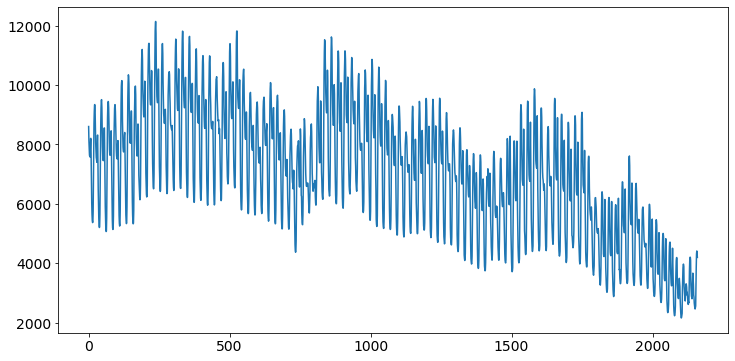

In [ ]:
predict_model(final_lgbm, heat_test)['Label'].plot()

# 지역난방 PROPHET

In [45]:
heat_data

,Unnamed: 0,시간,난방지수,연월일,일시
0,0,0,10695.0,2013-01-01,2013-01-01 00:00:00
1,1,1,10186.0,2013-01-01,2013-01-01 01:00:00
2,2,2,9765.0,2013-01-01,2013-01-01 02:00:00
3,3,3,9468.0,2013-01-01,2013-01-01 03:00:00
4,4,4,9378.0,2013-01-01,2013-01-01 04:00:00
...,...,...,...,...,...
52579,19,19,10267.0,2018-12-31,2018-12-31 19:00:00
52580,20,20,10752.0,2018-12-31,2018-12-31 20:00:00
52581,21,21,11190.0,2018-12-31,2018-12-31 21:00:00
52582,22,22,10962.0,2018-12-31,2018-12-31 22:00:00


In [46]:
series = heat_data[['일시', '난방지수']]
# idx = df[df[col].isna()].index.tolist()

series.columns = ['ds', 'y']

# 모델 생성
model = Prophet()
# 모델 학습
model.fit(series)

In [47]:
series['y'].max()

14352.0

In [ ]:
from tqdm import tqdm
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
# 최적의 매개변수 찾기 - 교차 검증 및 rmse 

# 예측값 상한,하한 제어 
series['cap'] = 15000
series['floor'] = 0

best_score = 13000

for changepoint_prior_scale in tqdm([0.0005, 0.001, 0.0025, 0.005, 0.008, 0.01]):
    for seasonality_prior_scale in [0.005, 0.01, 0.02, 0.03]:
        for holidays_prior_scale in [0.01, 0.05, 0.1, 0.5, 0.8, 1]:
            # 매개변수 각 조합에 대해 frophet 훈련
            m = Prophet(changepoint_prior_scale=changepoint_prior_scale, 
                        growth='logistic',      # 상한, 하한 제한
                        seasonality_mode='multiplicative',
                        yearly_seasonality=True,  # True
                        weekly_seasonality=20, 
                        daily_seasonality=False,  # false
                        seasonality_prior_scale = seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale, 
                       )
            m.fit(series)
            # 교차 검증 적용
            df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
            df_p = performance_metrics(df_cv)
            # 교차 검증 rmse 평균을 계산
            score = df_p['rmse'].mean()
            # rmse가 best_score보다 낮으면, 매개변수와 함께 기록
            if score < best_score:
                best_score = score
                best_parameters = {'changepoint_prior_scale':changepoint_prior_scale, 'seasonality_prior_scale':seasonality_prior_scale,
                                  'holidays_prior_scale':holidays_prior_scale}

print('best rmse score(in cross_val): ', best_score)
print('최적의 매개변수: ', best_parameters)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

 17%|████████████▊                                                                | 1/6 [2:14:51<11:14:16, 8091.36s/it]INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

 33%|██████████████████████████                                                    | 2/6 [4:33:27<9:08:14, 8223.50s/it]INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

 50%|███████████████████████████████████████                                       | 3/6 [7:19:51<7:31:22, 9027.35s/it]INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 23:00:00 and 2017-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

# 추론 및 결과 제출

In [ ]:
total_weather.columns

Index(['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '일시', '기온',
       '풍속', '습도', '지면온도'],
      dtype='object')

In [ ]:
test_.columns

Index(['일자', '시간', '구분', 'year', 'month', 'day', 'weekday', '기온', '풍속', '습도',
       '지면온도'],
      dtype='object')

In [ ]:
def valid_pred_origin(data, test, submission) :
  train_years = [2013,2014,2015,2016,2017]
  val_years = [2018]

  features = ['시간', '구분', 'year', 'month', 'day', 'weekday', '기온', '풍속', '습도', '지면온도']
  params = {
    'objective' : 'regression',
    'metric' : 'mae',
    'seed' : 42}

  # test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
  # test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
  # test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]
    
  # test['일자'] = pd.to_datetime(test['일자'])
  # test['year'] = test['일자'].dt.year
  # test['month'] = test['일자'].dt.month
  # test['day'] = test['일자'].dt.day
  # test['weekday'] = test['일자'].dt.weekday
  # test['구분'] = test['구분'].map(d_map)
  test[['시간']] = test[['시간']].astype('int')
  data[['시간']] = data[['시간']].astype('int')
  test_x = test[features]

  result = pd.DataFrame()
  for i in data['구분'].unique() :
    print('구분 {} 예측중'.format(i))
    df = data[data['구분'] == i].reset_index()
    test_div = test_x[test_x['구분'] == i]
    train = df[df['year'].isin(train_years)]

    val = df[df['year'].isin(val_years)]
    train_x = train[features]
    train_y = train['공급량']
    val_x = val[features]
    val_y = val['공급량']
    d_train = lgb.Dataset(train_x, train_y)
    d_val = lgb.Dataset(val_x, val_y)
    model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

    result = pd.concat([result, pd.DataFrame(model.predict(test_div))])

  return result.reset_index(drop = True)

In [ ]:
def valid_pred(data, test, submission, params_result) :
  train_years = [2013,2014,2015,2016,2017]
  val_years = [2018]

  features = ['구분', 'month', 'day', 'weekday', '시간']
  
  test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
  test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
  test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]
    
  test['일자'] = pd.to_datetime(test['일자'])
  test['year'] = test['일자'].dt.year
  test['month'] = test['일자'].dt.month
  test['day'] = test['일자'].dt.day
  test['weekday'] = test['일자'].dt.weekday
  test['구분'] = test['구분'].map(d_map)
  test_x = test[features]

  result = pd.DataFrame()
  for i in data['구분'].unique() :
    params = params_result['params_{}'.format(i)]
    # params = params_result[i][3]['params']
    print('구분 {} 예측중'.format(i))
    df = data[data['구분'] == i].reset_index()
    test_div = test_x[test_x['구분'] == i]
    train = df[features]
    train_y = df['공급량']
    model = lgb.LGBMRegressor(random_state = 42, n_jobs = -1, learning_rate = 0.01, 
                              num_leaves = params['num_leaves'],
                              max_depth = params['max_depth'],
                              min_child_weight = params['min_child_weight'],
                              n_estimators = params['n_estimators'],
                              subsample = params['subsample'],
                              feature_fraction = params['feature_fraction'],
                              reg_alpha = params['reg_alpha'],
                              reg_lambda = params['reg_lambda']
                              )
    model.fit(train, train_y)

    result = pd.concat([result, pd.DataFrame(model.predict(test_div))])

  return result.reset_index(drop = True)

In [ ]:
result.iloc[3]['params_0']

{'feature_fraction': 0.8322589525974274,
 'max_depth': 5,
 'min_child_weight': 4.16458921439483,
 'n_estimators': 8160,
 'num_leaves': 10,
 'reg_alpha': 0.07773102844857185,
 'reg_lambda': 0.2690508592079099,
 'subsample': 0.4573499618865127}

In [ ]:
# test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/sample_submission.csv')

In [ ]:
total_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368088 entries, 0 to 368087
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   연월일      368088 non-null  datetime64[ns]
 1   시간       368088 non-null  object        
 2   구분       368088 non-null  int64         
 3   공급량      368088 non-null  float64       
 4   year     368088 non-null  int64         
 5   month    368088 non-null  int64         
 6   day      368088 non-null  int64         
 7   weekday  368088 non-null  int64         
 8   일시       368088 non-null  datetime64[ns]
 9   기온       368088 non-null  float64       
 10  풍속       368088 non-null  float64       
 11  습도       368088 non-null  float64       
 12  지면온도     368088 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(5), object(1)
memory usage: 39.3+ MB


In [ ]:
pred_by_vaild_pred = valid_pred_origin(total_weather, test_, submission)

구분 0 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 140.744
[40]	valid_0's l1: 103.516
[60]	valid_0's l1: 98.827
[80]	valid_0's l1: 97.709
Early stopping, best iteration is:
[84]	valid_0's l1: 97.4403
구분 1 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 136.233
[40]	valid_0's l1: 91.5683
[60]	valid_0's l1: 84.5557
[80]	valid_0's l1: 82.9529
[100]	valid_0's l1: 82.4498
Early stopping, best iteration is:
[99]	valid_0's l1: 82.3676
구분 2 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 20.7421
[40]	valid_0's l1: 19.1119
[60]	valid_0's l1: 19.0167
Early stopping, best iteration is:
[52]	valid_0's l1: 18.9902
구분 3 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 91.9799
[40]	valid_0's l1: 65.3348
[60]	valid_0's l1: 61.4779
[80]	valid_0's l1: 60.5339
Early stopping, best iteration is:
[78]	valid_0's l1: 60.4647
구분 4 예측중
Training until validation sc

In [ ]:
pred_by_vaild_pred

,0
0,1804.949542
1,1552.760706
2,1465.385140
3,1468.283464
4,1565.950282
...,...
15115,369.216416
15116,358.843235
15117,338.265186
15118,297.886536


In [ ]:
pred_by_vaild_pred = valid_pred_origin(total, test, submission)

구분 0 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 200.604
[40]	valid_0's l1: 166.771
[60]	valid_0's l1: 162.126
[80]	valid_0's l1: 161.645
Early stopping, best iteration is:
[87]	valid_0's l1: 161.444
구분 1 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 188.062
[40]	valid_0's l1: 150.068
[60]	valid_0's l1: 143.81
[80]	valid_0's l1: 141.57
[100]	valid_0's l1: 140.478
Early stopping, best iteration is:
[104]	valid_0's l1: 140.375
구분 2 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 22.0943
[40]	valid_0's l1: 19.2375
[60]	valid_0's l1: 18.682
[80]	valid_0's l1: 18.4852
Early stopping, best iteration is:
[88]	valid_0's l1: 18.448
구분 3 예측중
Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 120.494
[40]	valid_0's l1: 98.4393
[60]	valid_0's l1: 94.2499
[80]	valid_0's l1: 93.2691
[100]	valid_0's l1: 92.7717
[120]	valid_0's l1: 92.9852
Early stopping, b

In [ ]:
pred_by_vaild_pred

,0
0,2139.311854
1,1894.782590
2,1841.735205
3,1854.982874
4,2010.593286
...,...
15115,356.877484
15116,356.877484
15117,330.044529
15118,306.180487


In [ ]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
test['구분'] = test['구분'].map(d_map)

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간']
test_x = test[features]

In [ ]:
test_x[test_x['구분'] == 0]

,구분,month,day,weekday,시간
0,0,1,1,1,1
1,0,1,1,1,2
2,0,1,1,1,3
3,0,1,1,1,4
4,0,1,1,1,5
...,...,...,...,...,...
2155,0,3,31,6,20
2156,0,3,31,6,21
2157,0,3,31,6,22
2158,0,3,31,6,23


In [ ]:
# preds = model.predict(test_x)

In [ ]:
# submission['공급량'] = preds
submission['공급량'] = pred_by_vaild_pred[0]

In [ ]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,1840.808379
1,2019-01-01 02 A,1580.758510
2,2019-01-01 03 A,1485.870820
3,2019-01-01 04 A,1485.870820
4,2019-01-01 05 A,1605.541430


In [ ]:
submission.to_csv('1025_outlier_replace_구분별_lgbm_base.csv', index=False)

# 결과 모음

## 1. lgbm model(점수 : 0.1138185916)
- 데이터의 outlier와 튀는 부분을 구분별로 나누어 처리하는 함수로 전처리
- 그 후 데이터를 구분별로 나누어 lgbm을 수행

In [ ]:
total = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

구분 0 시행중
구분 0의 공급량 plot


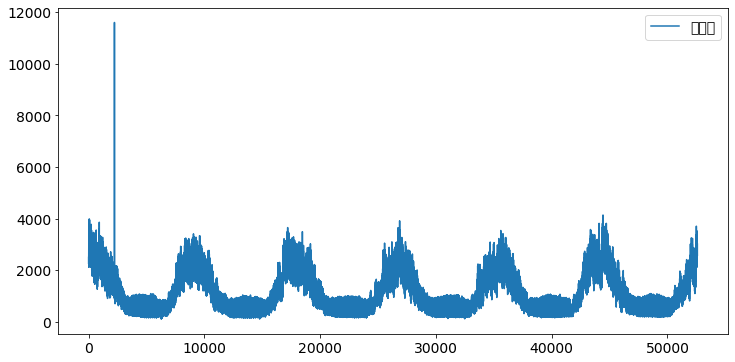

,ds,y
2230,2013-04-03 22:00:00,11593.617
25564,2015-12-02 04:00:00,3051.177


구분 0의 outlier 처리 후 plot


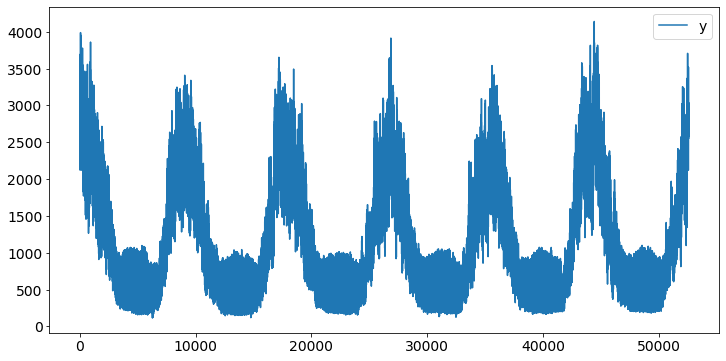

구분 1 시행중
구분 1의 공급량 plot


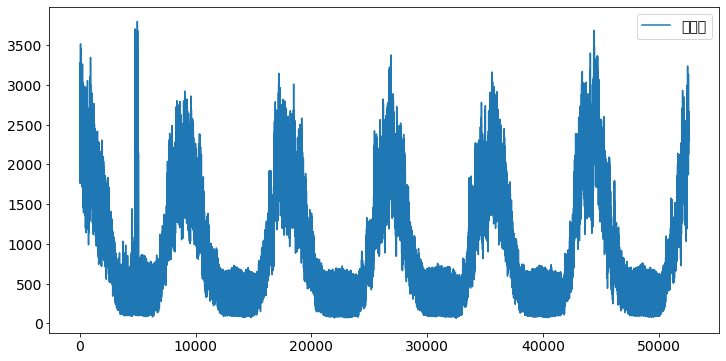

,ds,y
3711,2013-06-04 15:00:00,1032.845
4507,2013-07-07 19:00:00,1441.813
4555,2013-07-09 19:00:00,1086.749
4747,2013-07-17 19:00:00,1620.277
4771,2013-07-18 19:00:00,3704.901
4891,2013-07-23 19:00:00,1133.597
4939,2013-07-25 19:00:00,1474.949
4963,2013-07-26 19:00:00,3798.613
4987,2013-07-27 19:00:00,3682.997
5011,2013-07-28 19:00:00,3412.565


구분 1의 outlier 처리 후 plot


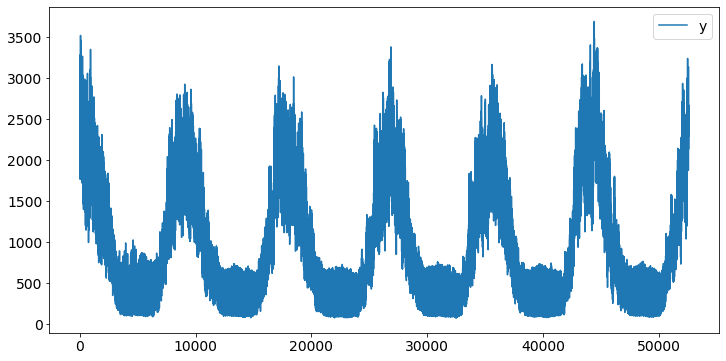

구분 2 시행중
구분 2의 공급량 plot


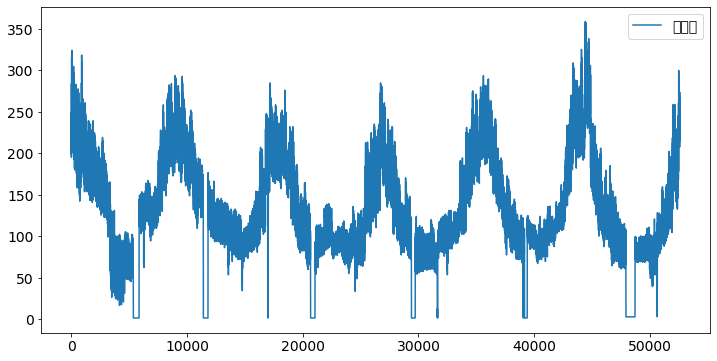

,ds,y
5870,2013-09-02 14:00:00,104.578
11413,2014-04-21 13:00:00,148.578
11822,2014-05-08 14:00:00,103.778
16978,2014-12-09 10:00:00,185.378
17026,2014-12-11 10:00:00,127.778
39039,2017-06-15 15:00:00,101.378
39062,2017-06-16 14:00:00,104.578
39157,2017-06-20 13:00:00,101.378
39398,2017-06-30 14:00:00,108.578


구분 2의 outlier 처리 후 plot


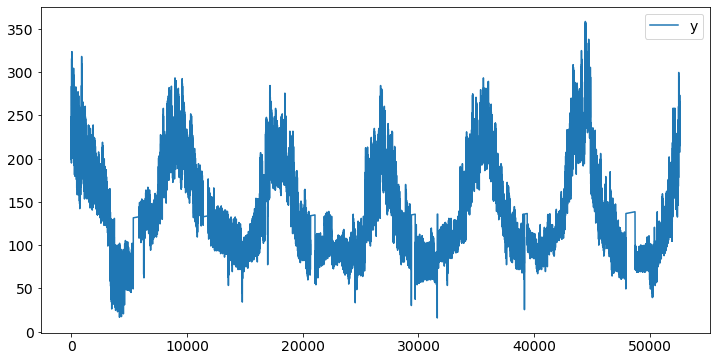

구분 3 시행중
구분 3의 공급량 plot


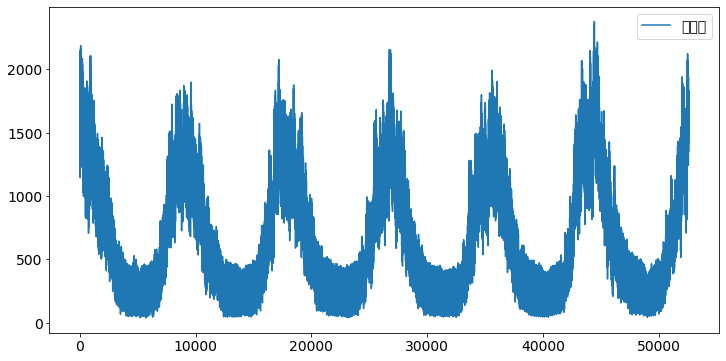

,ds,y
5856,2013-09-02 00:00:00,130.836
5862,2013-09-02 06:00:00,293.556
21990,2015-07-06 06:00:00,296.533
22662,2015-08-03 06:00:00,214.533
22686,2015-08-04 06:00:00,222.693
22734,2015-08-06 06:00:00,260.613
22830,2015-08-10 06:00:00,227.333
22998,2015-08-17 06:00:00,252.053
23137,2015-08-23 01:00:00,114.613
23166,2015-08-24 06:00:00,256.533


구분 3의 outlier 처리 후 plot


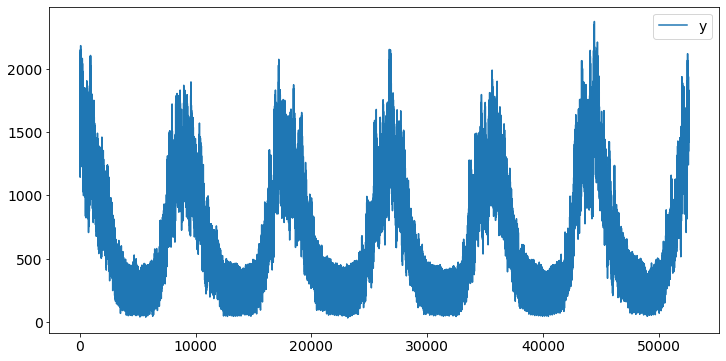

구분 4 시행중
구분 4의 공급량 plot


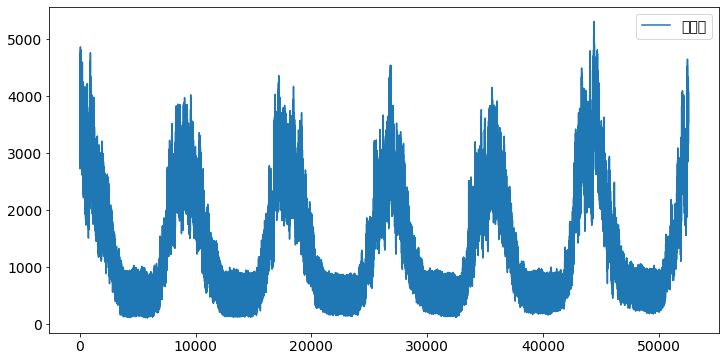

,ds,y
5692,2013-08-26 04:00:00,242.509


구분 4의 outlier 처리 후 plot


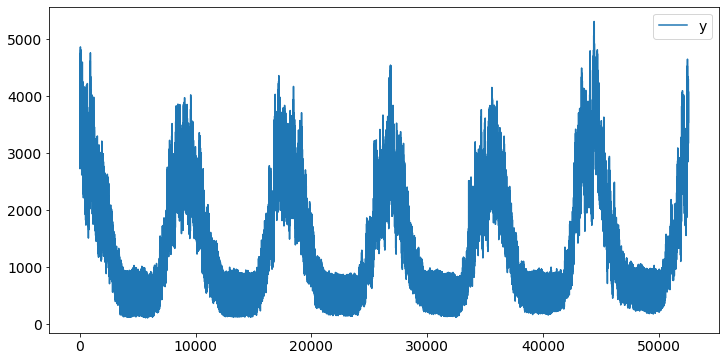

구분 5 시행중
구분 5의 공급량 plot


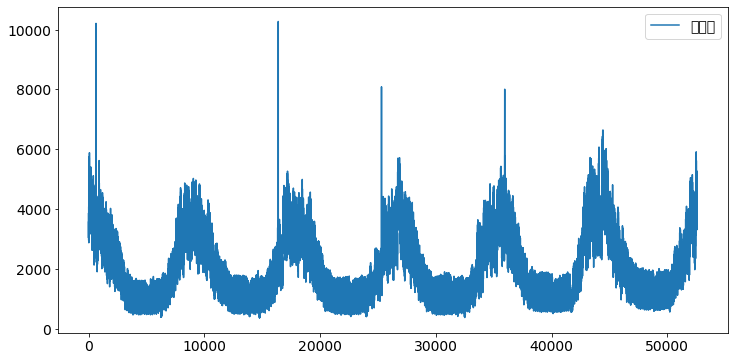

,ds,y
647,2013-01-27 23:00:00,10207.077
16391,2014-11-14 23:00:00,10271.437
25309,2015-11-21 13:00:00,8086.693
35953,2017-02-07 01:00:00,8005.709
35954,2017-02-07 02:00:00,5785.813


구분 5의 outlier 처리 후 plot


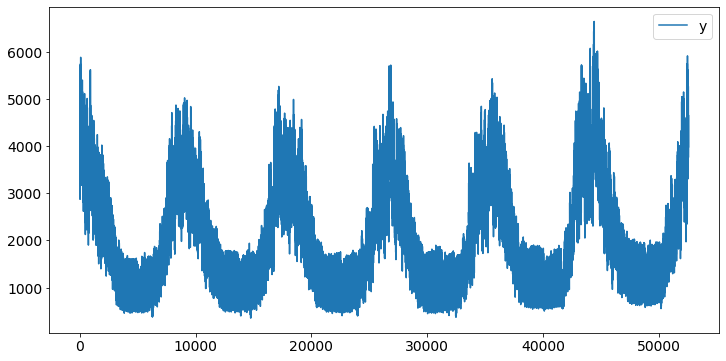

구분 6 시행중
구분 6의 공급량 plot


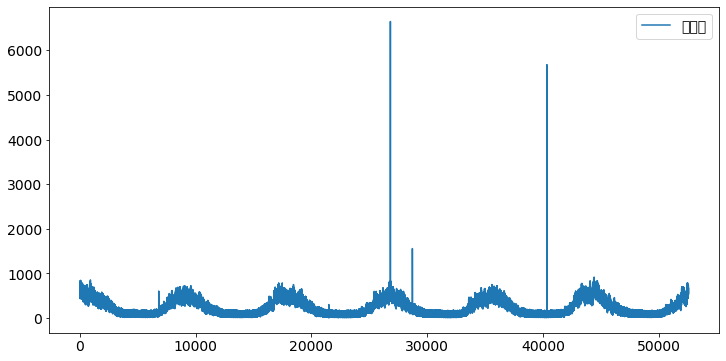

,ds,y
6822,2013-10-12 06:00:00,606.100
9083,2014-01-14 11:00:00,540.804
9085,2014-01-14 13:00:00,720.196
11894,2014-05-11 14:00:00,210.260
17492,2014-12-30 20:00:00,788.092
21517,2015-06-16 13:00:00,302.996
21519,2015-06-16 15:00:00,125.316
26832,2016-01-24 00:00:00,3227.524
26833,2016-01-24 01:00:00,6644.788
28732,2016-04-12 04:00:00,1557.836


구분 6의 outlier 처리 후 plot


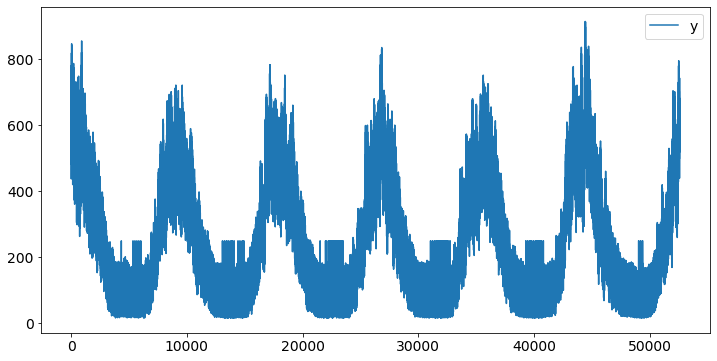

In [ ]:
total = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)
total['연월일'] = pd.to_datetime(total['연월일'])
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

# 구분별로 함수를 사용해서 대체를 해보는 방법 ㄱㄱ
def outlier_prophet(data) :
  uniq = data['구분'].unique()
  result = pd.DataFrame()
  for i in uniq :
    print('구분 {} 시행중'.format(i))
    total_ = data[data['구분'] == i].reset_index()
    df = data[data['구분'] == i].reset_index()
    print('구분 {}의 공급량 plot'.format(i))
    df[['공급량']].plot()
    plt.show()
    df['aft_1hour'] = df['공급량'].shift(-1)
    df['bef_1hour'] = df['공급량'].shift(1)
    df['bef_diff'] = abs((df['bef_1hour'] - df['공급량'])/df['공급량'])
    df['aft_diff'] = abs((df['aft_1hour'] - df['공급량'])/df['공급량'])
    df['aft_remove'] = df['aft_diff'].shift(1)
    df['bef_remove'] = df['bef_diff'].shift(-1)
    idx = df[((df['bef_remove'] > 1) | (df['aft_remove'] > 1)) & (df['공급량'] > 100) | (df['공급량'].isin([1.378, 2.756]))].index.tolist()
    if len(idx) != 0 :
      # print(idx[ : 5])
      # print(idx[-5 : ])
      series = total_[['연월일', '시간', '공급량']]
      series[['시간']] = series[['시간']] - 1
      for k in range(len(series)) :
        if series.iloc[k]['시간'] in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] :
          series.iloc[k, 1] = str(series.iloc[k]['시간']).zfill(2)
      # display(series.head())
      # display(series.iloc[idx])
      series['연월일시'] = series['연월일'].astype('str') + '-' + series['시간'].astype('str')
      series = series[['연월일시', '공급량']]

      # 데이터 타입 변경
      series['연월일시']= pd.to_datetime(series['연월일시'])
      series.columns = ['ds', 'y']
      display(series.iloc[idx])
      # 1.378과 2.756인 부분을 구분 2의 평균으로 대체한 뒤, 시계열을 해보면 어떨까
      for l in series[series['y'] <= 15]['y'].index.tolist() :
        series.at[l, 'y'] = np.mean(series[~series['y'].isin([1.378, 2.756])]['y'])

      # display(series.iloc[idx])
      # 모델 생성
      model = Prophet()

      # 모델 학습
      model.fit(series)

      outlier_2 = model.predict(series.iloc[idx][['ds']])

      outlier_series = series.copy()
      for j in range(len(outlier_2)) :
        outlier_series.at[outlier_series['ds'] == outlier_2.iloc[j]['ds'], 'y'] = outlier_2.iloc[j]['yhat']

      print('구분 {}의 outlier 처리 후 plot'.format(i))
      # display(series.iloc[idx])
      # display(outlier_series.iloc[idx])
      outlier_series[['y']].plot()
      plt.show()

      total_ = pd.concat([total_, outlier_series[['y']]], axis = 1)
      total_ = total_.set_index(['index'])
      total_ = total_[['연월일', '시간', '구분', 'y', 'year', 'month', 'day', 'weekday']]
      total_.columns = ['연월일', '시간', '구분', '공급량', 'year', 'month',' day', 'weekday']

      result = pd.concat([result, total_])
    
    else : 
      result = pd.concat([result, total_])

  return result.sort_index()    

total_ = outlier_prophet(total)

In [ ]:
def valid_pred(data, test, submission) :
  train_years = [2013,2014,2015,2016,2017]
  val_years = [2018]
  params = {
    'objective' : 'regression',
    'metric' : 'mae',
    'seed' : 42
  }
  features = ['구분', 'month', 'day', 'weekday', '시간']
  
  test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
  test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
  test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]
    
  test['일자'] = pd.to_datetime(test['일자'])
  test['year'] = test['일자'].dt.year
  test['month'] = test['일자'].dt.month
  test['day'] = test['일자'].dt.day
  test['weekday'] = test['일자'].dt.weekday
  test['구분'] = test['구분'].map(d_map)
  test_x = test[features]

  result = pd.DataFrame()
  for i in data['구분'].unique() :
    print('구분 {} 예측중'.format(i))
    df = data[data['구분'] == i].reset_index()
    test_div = test_x[test_x['구분'] == i]
    train = df[df['year'].isin(train_years)]

    val = df[df['year'].isin(val_years)]
    train_x = train[features]
    train_y = train['공급량']
    val_x = val[features]
    val_y = val['공급량']
    d_train = lgb.Dataset(train_x, train_y)
    d_val = lgb.Dataset(val_x, val_y)
    model = lgb.train(params, d_train, 5000, d_val, verbose_eval=20,  early_stopping_rounds=10)

    result = pd.concat([result, pd.DataFrame(model.predict(test_div))])

  return result.reset_index(drop = True)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/가스공급량 수요예측 모델개발/data/sample_submission.csv')

In [ ]:
pred_by_vaild_pred = valid_pred(total_, test, submission)

In [ ]:
pred_by_vaild_pred

,0
0,2139.311854
1,1894.782590
2,1841.735205
3,1854.982874
4,2010.593286
...,...
15115,356.968681
15116,356.968681
15117,336.648354
15118,306.642417


In [ ]:
# submission['공급량'] = preds
submission['공급량'] = pred_by_vaild_pred[0]

In [ ]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2139.311854
1,2019-01-01 02 A,1894.782590
2,2019-01-01 03 A,1841.735205
3,2019-01-01 04 A,1854.982874
4,2019-01-01 05 A,2010.593286


In [ ]:
submission.to_csv('1020_baseline_outlier_replace_구분별lgbm.csv', index=False)